Scoring the models and visualising the scores

In [1]:
from pathlib import Path
from matplotlib.patches import Patch
import os
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from datasets import synth_dataset 
import visualisations
from visualisations import ModelVisualiser, SynthVecDataVisualiser
from visualisations import visualise_data, visualise_model

## All scores

In [2]:
full_df = pd.read_csv("./all_scores.csv", index_col=0)

In [3]:
full_df

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,SCN+,SCN++
0,AE,standardS_MNIST,MNIST,11.0,0.004052,0.089621,-64.377853,0.401517,NaN,0.709440,...,NaN,1.000000,0.756458,0.563324,0.564627,NaN,NaN,NaN,NaN,NaN
1,BetaVAE,standardS_MNIST,MNIST,11.0,0.001790,0.027738,-41.350979,0.187705,NaN,0.531160,...,NaN,1.000000,0.265083,0.292283,0.328937,NaN,NaN,NaN,NaN,NaN
2,BaseSAE,standardS_MNIST,MNIST,11.0,0.002576,0.047337,-33.894054,0.225092,NaN,0.676901,...,NaN,1.000000,0.724167,0.490122,0.492243,NaN,NaN,NaN,NaN,NaN
3,XVAE,standardS_MNIST,MNIST,11.0,0.001478,0.010410,-41.246078,0.149479,NaN,0.622676,...,0.8848,1.000000,0.529208,0.248376,0.357323,0.438948,0.428877,0.435307,NaN,NaN
4,XAE,standardS_MNIST,MNIST,11.0,0.002039,0.021456,-33.865906,0.166508,NaN,0.665805,...,0.9685,1.000000,0.832000,0.663157,0.663845,0.957662,0.850308,0.712499,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,XCVAE,standardrandom_seed121_MNIST,MNIST,121.0,0.001494,0.006132,-40.487423,0.049578,NaN,0.547185,...,0.9159,1.000000,0.350500,0.140312,0.278521,0.220614,0.216834,0.225061,0.287574,0.214441
123,XCAE,standardrandom_seed17_MNIST,MNIST,17.0,0.002075,0.006345,-35.792969,0.058636,NaN,0.485424,...,0.9824,0.985313,0.864563,0.658508,0.663880,0.916919,0.837495,0.751944,0.853597,0.766642
124,XVAE,standardrandom_seed121_MNIST,MNIST,121.0,0.001474,0.006634,-42.418381,0.044134,NaN,0.531781,...,0.8636,1.000000,0.353292,0.146205,0.215450,0.223959,0.224730,0.231500,0.284556,0.261834
125,XCAE,standardrandom_seed13_MNIST,MNIST,13.0,0.002100,0.005730,-34.179844,0.056204,NaN,0.492657,...,0.9841,0.981229,0.862437,0.691804,0.694761,0.914358,0.842986,0.739346,0.854177,0.774579


In [4]:
full_df.loc[full_df["model_name"]=="CausalVAE"]

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,SCN+,SCN++
126,CausalVAE,fc_pd_1D_Pendulum,Pendulum,11.0,0.013108,0.370738,-68.255051,1.131688,0.021607,0.767278,...,NaN,1.0,0.206187,0.028597,0.056837,0.0,0.0,0.0,-1.423297,-1.435666


In [19]:
import copy
full_df2 = copy.deepcopy(full_df)

In [20]:
full_df2 = full_df2.drop(full_df2.loc[full_df2['model_version'].isna()].index)
#full_df2 = full_df2.drop(full_df2.loc[full_df2['EQV']<0].index)
#full_df2 = full_df2.drop(full_df2.loc[full_df2['INV']<0].index)
#full_df2 = full_df2.drop(full_df2.loc[full_df2['IMQ']<=0.].index)
#full_df2 = full_df2.drop(full_df2.loc[full_df2['RBF']<=0.].index)
#full_df2 = full_df2.drop(full_df2.loc[full_df2['SCN']<=0.].index)
#full_df2 = full_df2.drop(full_df2.loc[full_df2['SCN']>1.].index)

In [21]:
import re

def extract_version_name(full_name):
    new_name = full_name.replace("_MNIST","")
    new_name = new_name.replace("_CelebA","")
    new_name = new_name.replace("_Pendulum","")
    new_name = re.sub("random_seed\d+","", new_name)
    return new_name

def extract_model_family(full_name):
    if full_name=="CausalVAE":return full_name
    new_name = full_name.replace("X","")
    new_name = new_name.replace("C","")
    return new_name

def change_name(full_name):
    new_name = full_name.replace("BaseSAE","SAE")
    new_name = new_name.replace("BetaVAE","VAE")
    return new_name

def extract_type(full_name):
    model_type = "N"
    if 'X' in full_name: model_type = "X"
    if 'XC' in full_name: model_type = "XC"
    return model_type

In [22]:
def is_Xnet(name):
    return 'X' in name
def is_XCnet(name):
    return 'XC' in name
    

In [23]:
full_df2["model_version"] = full_df2["model_version"].apply(extract_version_name)
full_df2["model_name"] = full_df2["model_name"].apply(change_name)
full_df2["model_family"] = full_df2["model_name"].apply(extract_model_family)
full_df2["model_type"] = full_df2["model_name"].apply(extract_type)

In [24]:
full_df2 = full_df2.drop(full_df2.loc[full_df2['model_family']=='WAE'].index)

In [25]:
full_df2

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,SCN+,SCN++,model_family,model_type
0,AE,standardS,MNIST,11.0,0.004052,0.089621,-64.377853,0.401517,NaN,0.709440,...,0.756458,0.563324,0.564627,NaN,NaN,NaN,NaN,NaN,AE,N
1,VAE,standardS,MNIST,11.0,0.001790,0.027738,-41.350979,0.187705,NaN,0.531160,...,0.265083,0.292283,0.328937,NaN,NaN,NaN,NaN,NaN,VAE,N
2,SAE,standardS,MNIST,11.0,0.002576,0.047337,-33.894054,0.225092,NaN,0.676901,...,0.724167,0.490122,0.492243,NaN,NaN,NaN,NaN,NaN,SAE,N
3,XVAE,standardS,MNIST,11.0,0.001478,0.010410,-41.246078,0.149479,NaN,0.622676,...,0.529208,0.248376,0.357323,0.438948,0.428877,0.435307,NaN,NaN,VAE,X
4,XAE,standardS,MNIST,11.0,0.002039,0.021456,-33.865906,0.166508,NaN,0.665805,...,0.832000,0.663157,0.663845,0.957662,0.850308,0.712499,NaN,NaN,AE,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,XCVAE,standard,MNIST,121.0,0.001494,0.006132,-40.487423,0.049578,NaN,0.547185,...,0.350500,0.140312,0.278521,0.220614,0.216834,0.225061,0.287574,0.214441,VAE,XC
123,XCAE,standard,MNIST,17.0,0.002075,0.006345,-35.792969,0.058636,NaN,0.485424,...,0.864563,0.658508,0.663880,0.916919,0.837495,0.751944,0.853597,0.766642,AE,XC
124,XVAE,standard,MNIST,121.0,0.001474,0.006634,-42.418381,0.044134,NaN,0.531781,...,0.353292,0.146205,0.215450,0.223959,0.224730,0.231500,0.284556,0.261834,VAE,X
125,XCAE,standard,MNIST,13.0,0.002100,0.005730,-34.179844,0.056204,NaN,0.492657,...,0.862437,0.691804,0.694761,0.914358,0.842986,0.739346,0.854177,0.774579,AE,XC


In [242]:
sdf = full_df2.loc[full_df2['sparsity'].dropna().index][['dataset','model_name',"model_version",'sparsity','model_family']]
fs = sdf.loc[sdf['dataset']=="celeba"]['sparsity'].mean()
ps = (fs/0.5)*100
ps, fs

(48.4375062584877, 0.2421875312924385)

In [14]:
sdf = full_df2.loc[full_df2['sparsity'].dropna().index]
sdf

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,SCN+,SCN++,model_family,model_type
3,XVAE,standardS_MNIST,MNIST,11.0,0.001478,0.010410,-41.246078,0.149479,NaN,0.622676,...,0.529208,0.248376,0.357323,0.438948,0.428877,0.435307,NaN,NaN,VAE,X
4,XAE,standardS_MNIST,MNIST,11.0,0.002039,0.021456,-33.865906,0.166508,NaN,0.665805,...,0.832000,0.663157,0.663845,0.957662,0.850308,0.712499,NaN,NaN,AE,X
5,XSAE,standardS_MNIST,MNIST,11.0,0.002069,0.031657,-39.002205,0.207601,NaN,0.677604,...,0.715833,0.503911,0.505786,0.956628,0.729223,0.290482,NaN,NaN,SAE,X
8,XAE,standard_MNIST,MNIST,11.0,0.002213,0.009590,-43.094986,0.077665,NaN,0.528157,...,0.841792,0.632939,0.636814,0.911862,0.830681,0.701849,NaN,NaN,AE,X
9,XVAE,standard_MNIST,MNIST,11.0,0.001736,0.005425,-41.596916,0.044561,NaN,0.567471,...,0.358875,0.141975,0.212123,0.224488,0.224106,0.219990,NaN,NaN,VAE,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,XVAE,standard_MNIST,MNIST,17.0,0.001799,0.008522,-42.009193,0.043939,NaN,0.549007,...,0.352625,0.142397,0.212103,0.219137,0.220660,0.228902,0.280978,0.252564,VAE,X
122,XCVAE,standard_MNIST,MNIST,121.0,0.001494,0.006132,-40.487423,0.049578,NaN,0.547185,...,0.350500,0.140312,0.278521,0.220614,0.216834,0.225061,0.287574,0.214441,VAE,XC
123,XCAE,standard_MNIST,MNIST,17.0,0.002075,0.006345,-35.792969,0.058636,NaN,0.485424,...,0.864563,0.658508,0.663880,0.916919,0.837495,0.751944,0.853597,0.766642,AE,XC
124,XVAE,standard_MNIST,MNIST,121.0,0.001474,0.006634,-42.418381,0.044134,NaN,0.531781,...,0.353292,0.146205,0.215450,0.223959,0.224730,0.231500,0.284556,0.261834,VAE,X


In [93]:
(sdf.loc[sdf['dataset']=="celeba"]['sparsity']*(32*32))

164    248.000031
165    248.000031
166    248.000031
168    248.000031
169    248.000031
170    248.000031
171    248.000031
172    248.000031
173    248.000031
174    248.000046
Name: sparsity, dtype: float64

In [30]:
32*32

1024

# Number of parameters

In [1]:
def get_pytorch_total_params(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
sizes_df = pd.DataFrame()

In [9]:
model_names = ["AE","XAE","BetaVAE","XVAE","BaseSAE","XSAE"]
model_versions = ["StandardS","Standard","xunit_dim4"]
i = 0
for model_name in model_names: 
    for v in model_versions: 
        #if model_name in ["BaseSAE","XSAE"] and v in ["v32_big","v32_x4_big"]: continue
        if 'X' not in model_name and v in ["xunit_dim4","v32_x4_big"]: continue
        i +=1
        params = {"model_name":model_name,
                  "model_version":v,
                  "data" : "CelebA" if v in ["v32_big","v32_x4_big"] else "MNIST" }
        # load handler
        handler = ModelHandler.from_config(**params)
        sizes_df.loc[i,"name"] = model_name
        sizes_df.loc[i,"version"] = v
        sizes_df.loc[i,"size"] = get_pytorch_total_params(handler.model)
        

configs/models/AE/StandardS.yaml
128
Initialising schedulers Manager...
AE model hanlder loaded.
configs/models/AE/Standard.yaml
128
Initialising schedulers Manager...
AE model hanlder loaded.
configs/models/XAE/StandardS.yaml
128
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Tau set to 1.0
configs/models/XAE/Standard.yaml
128
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Tau set to 1.0
configs/models/XAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Explicit mode ON
XAE model hanlder loaded.
Tau set to 1.0
configs/models/BetaVAE/StandardS.yaml
128
Initialising schedulers Manager...
Variational mode ON
BetaVAE model hanlder loaded.
configs/models/BetaVAE/Standard.yaml
128
Initialising schedulers Manager...
Variational mode ON
BetaVAE model hanlder loaded.
configs/models/XVAE/StandardS.yaml
128
Initialising schedulers Manager...
Variational mode ON
Explicit mode ON
XVAE model hanlder loaded.
Tau set to 1.0
configs/

In [10]:
sizes_df

,name,version,size
1,AE,StandardS,309973.0
2,AE,Standard,423259.0
3,XAE,StandardS,310984.0
4,XAE,Standard,425677.0
5,XAE,xunit_dim4,313936.0
6,BetaVAE,StandardS,186025.0
7,BetaVAE,Standard,298771.0
8,XVAE,StandardS,187036.0
9,XVAE,Standard,301189.0
10,XVAE,xunit_dim4,188836.0


# Disentanglement scoring 

## Visual datasets

In [ ]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
model_names =  ["XSAE"]#,"RSAE","RAE","AE","BetaVAE"]
model_versions = [["standardS"]]
                  #, ["standardS", "standard","v121"], 
                  #["standardS", "standard","v121"],["standardS", "standard","v121"], 
                  #["standardS", "standard"]]

In [ ]:
# X-class models
model_names = ["XAE","XSAE"]#,"XVAE","XCAE", "XCSAE"
model_versions = [["uniform","multidim"]]*2
#model_versions = [["standardS","standard","v121"]]*3 + [["standardS"]]*2

In [ ]:
model_params=[]
for i,model_n in enumerate(model_names): 
    for model_v in model_versions[i]:
        _params = {"model_name":model_n,
                   "model_version":model_v,
                   "data":"MNIST" if model_v!="v121" else "3DS"}
        model_params.append(_params)

In [ ]:
scores=[]
for params in model_params:
        handler = (ModelHandler.from_config(**params, verbose=False))
        handler.config["logging_params"]["save_dir"] = "./logs"
        scores.append(handler.load_scores(name="scoring"))

In [ ]:
# fill the dataframe
scores_df = pd.DataFrame()
scores_df["model_name"] = [params["model_name"] for params in model_params]
scores_df["model_version"] = [params["model_version"] for params in model_params]
scores_df["dataset"] = [params["data"] for params in model_params]
for i,score_set in enumerate(scores):
    try: 
        for k,v in score_set.items():
            scores_df.loc[i,k] = v
    except AttributeError: 
        continue

In [ ]:
scores_df.drop("CAT", axis=1)

In [ ]:
full_df.to_csv("Scores_full.csv")

In [ ]:
full_df = pd.read_csv("Scores_full.csv", index_col=0)

In [ ]:
full_df = pd.concat([scores_df, full_df], ignore_index=True)

In [ ]:
full_df

## Vector datasets

In [ ]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
data_versions = ["standard","discrete","continuous","big"]
model_names = ["VecESAE","VecSAE","VecVAE","VecRSAE","VecRAE","VecAE"]

model_versions = [["standard"], ["standard", "full"], ["standard"], ["standard","full"], ["standard"], ["standard"]]

model_params=[]
for data_v in data_versions:
    for i,model_n in enumerate(model_names): 
        for model_v in model_versions[i]:
            _params = {"model_name":model_n,
                       "model_version":model_v,
                       "data":"SynthVec",
                       "data_version":data_v}
            model_params.append(_params)

In [ ]:
# collect the handlers
scores=[]
for params in model_params:
        handler = (VectorModelHandler.from_config(**params, verbose=False))
        handler.config["logging_params"]["save_dir"] = "./logs"
        scores.append(handler.load_scores(name="scoring_noises"))

In [ ]:
# fill the dataframe
scores_df = pd.DataFrame()
scores_df["model_name"] = [params["model_name"] for params in model_params]
scores_df["model_version"] = [params["model_version"] for params in model_params]
scores_df["data_version"] = [params["data_version"] for params in model_params]
for i,score_set in enumerate(scores):
    try: 
        for k,v in score_set.items():
            scores_df.loc[i,k] = v
    except AttributeError: 
        continue

In [ ]:
scores_df.to_csv("VecScoresNoises.csv")

In [ ]:
try: scores_df = pd.read_csv("dfhs.csv", index_col=0)

## Visualise scores

In [40]:
def plot_metrics(dataframe, metric_name, **kwargs):
    """Plots the selected metric against all the models that satisfy the specified requirement. 
    To specify a requirement pass a 'key' argument and a 'value' argument. 
    To specify a group pass a group_key argument"""
    fig, ax = plt.subplots(figsize=kwargs.get('figsize',(10,8)))
    key=kwargs.get('key');values=kwargs.get('values')
    key_name_in = kwargs.get("key_name_in",False)
    title_in = kwargs.get("title_in",True)
    group_key=kwargs.get('group_key')
    # filtering the dataframe based on model_version attribute
    df = dataframe.loc[dataframe[key].isin(values)]
    ordered_names = df.sort_values(metric_name)["model_name"].loc[df[metric_name].notna()] # ordering for ascending metric value
    group_names = {i:v for  i,v in enumerate(df[group_key].unique())}
    group_codes = {v:i for i,v in group_names.items()}
    colors = {n:f'C{n+1}' for n in range(len(group_names))}
    tps = set()
    tick_names = []
      
    j = 0 
    # adding all the bars (one by one)
    for i,t in zip(ordered_names.index, ordered_names):
        score = df.loc[i,metric_name]
        group = df.loc[i,group_key]
        k = df.loc[i,key]
        c = colors[group_codes[group]]
        plt.bar(j, score, color=c, edgecolor='k', linewidth=2)
        tps.add(group_codes[group])
        tick_name = k+"_"+group if key_name_in else group 
        tick_names.append(tick_name)
        j+=1
    
    legend_elements = [Patch(facecolor=colors[name], label=group_names[name]) for name in tps]
    legend = plt.legend(handles=legend_elements, title=key)
    plt.xticks(np.arange(len(ordered_names)), tick_names, rotation='vertical')
    plt.ylabel(f'{metric_name} Score')
    if title_in: plt.title(f'{values} on {metric_name}')
    plt.grid(linestyle='--',axis='y')
    plt.tight_layout()

In [59]:
full_df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP,FID_rec,FID_gen,INV,EQV,SCN,FID_trv,inference
0,XSAE,standardS_MNIST,MNIST,11,0.002425,0.019672,-34.468983,0.208302,NaN,0.655058,0.043108,NaN,0.030,83.344602,80.920696,20.926472,33.319210,5.416009,NaN,NaN
1,XSAE,standard_MNIST,MNIST,11,0.002434,0.014305,-52.094749,0.090750,NaN,0.551446,0.042508,NaN,0.042,80.746022,77.984038,90.275177,137.146759,11.070246,NaN,NaN
2,XAE,standard_MNIST,MNIST,11,0.002346,0.013762,-38.723152,0.067907,NaN,0.514539,0.046793,NaN,0.008,78.020279,77.349419,81.108719,139.013794,11.334163,NaN,NaN
3,XCAE,xunit_dim6_MNIST,MNIST,11,0.002627,0.016636,-96.157974,0.431432,NaN,0.701792,0.015413,NaN,0.010,84.526234,80.029953,28.466396,34.054249,5.329462,NaN,NaN
4,XCAE,xunit_dim5_MNIST,MNIST,11,0.002812,0.017679,-53.434628,0.283264,NaN,0.647231,0.087051,NaN,0.020,84.872292,80.148314,26.627775,34.893372,5.511103,NaN,NaN


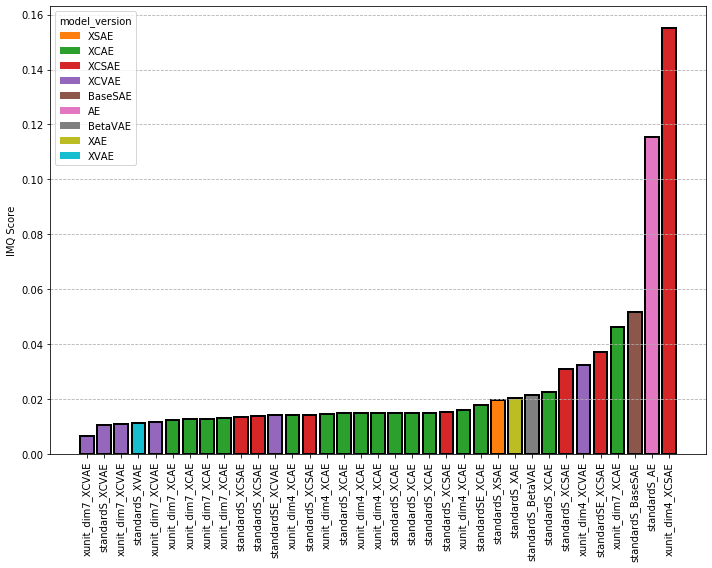

In [60]:
fig = plot_metrics(full_df2, metric_name="IMQ", key="model_version",
                   values=["standardS","standardSE"]+[f"xunit_dim{i}" for i in [4,7]], 
                   group_key="model_name", key_name_in=True, title_in=False, figsize=(10,8))
#fig = plot_metrics(full_df, metric_name="FID", key="dataset",value="3DS", group_key="model_version",figsize=(6,6))

In [ ]:
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="MNIST", group_key="model_version",figsize=(8,8))
fig = plot_metrics(full_df, metric_name="IRS", key="dataset",value="3DS", group_key="model_name",figsize=(6,6))

In [ ]:
#TODO: adjust plotting for visual datasets

In [11]:
full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4'])]

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,INV,EQV,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,model_family
14,SAE,standardS,MNIST,11.0,0.002397,0.051606,-37.119141,0.248815,NaN,0.674850,...,0.672559,NaN,5.017962,NaN,1.0000,0.676788,NaN,NaN,NaN,SAE
15,VAE,standardS,MNIST,11.0,0.001683,0.021405,-35.843693,0.146933,NaN,0.581233,...,0.804501,NaN,2.299924,NaN,0.7734,0.709551,NaN,NaN,NaN,VAE
16,AE,standardS,MNIST,11.0,0.004981,0.115413,-66.567383,0.448714,NaN,0.728408,...,0.828893,NaN,4.018983,NaN,0.9921,0.830705,NaN,NaN,NaN,AE
21,XVAE,standardS,MNIST,11.0,0.001587,0.011306,-43.764526,0.156623,NaN,0.598862,...,0.840001,0.991257,3.292447,82.933933,0.8358,0.682406,0.985526,0.8134,NaN,VAE
23,XCAE,standardS,MNIST,11.0,0.001860,0.022484,-42.722870,0.208227,NaN,0.635522,...,0.880916,0.978832,5.641273,79.229177,0.9686,0.883969,0.979923,0.9750,NaN,AE
24,XCSAE,standardS,MNIST,11.0,0.002234,0.031179,-38.540421,0.216116,NaN,0.639433,...,0.738277,0.941617,5.513371,79.618860,0.9766,0.796955,0.944498,0.9666,NaN,SAE
25,XAE,standardS,MNIST,11.0,0.002038,0.020385,-33.257256,0.170206,NaN,0.697051,...,0.716242,0.949304,5.378277,78.792896,0.9688,0.739611,0.951088,0.9687,NaN,AE
26,XSAE,standardS,MNIST,11.0,0.002308,0.034846,-34.935459,0.205883,NaN,0.660350,...,0.729228,0.933393,5.337350,80.216930,0.9766,0.770027,0.941841,0.9786,NaN,SAE
28,XCVAE,standardS,MNIST,11.0,0.001528,0.010458,-50.404320,0.210037,NaN,0.506021,...,0.766186,0.962740,2.364816,82.289695,0.8359,0.653691,0.950733,0.8318,NaN,VAE
36,XCAE,standardS,MNIST,37.0,0.002044,0.017828,-37.047951,0.172622,NaN,0.604936,...,0.835025,0.973715,5.632848,81.174608,0.9376,0.841968,0.975136,0.9454,0.208333,AE


In [332]:


sns.set_context("poster", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   
sns.set_theme(style="whitegrid")

In [238]:
full_df2.loc[full_df2['dataset']=='celeba']

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,SCN,SCN_w,inference,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,model_family,model_type


[Text(0, 0.5, ''), Text(0.5, 0, '')]

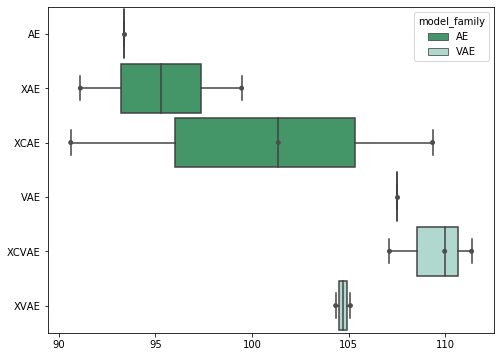

In [39]:
fig = plt.figure(figsize=(8,6))
#df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = full_df2.loc[(full_df2['dataset']=='celeba')]
df = df.sort_values(by=["model_family","model_name"])
#df = df.drop(df.loc[df['EQV'].isna()].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.boxplot(x='FID_trv',y="model_name", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.9).set(xlabel=None, ylabel=None)
sns.swarmplot(x='FID_trv',y="model_name", data=df, color=".3").set(xlabel=None, ylabel=None)

In [172]:
fig = plt.figure(figsize=(8,6))
df = full_df2.loc[full_df2['dataset']=='MNIST']
df = df.drop(df.loc[df['model_name']=="AVAE"].index)
df = df.sort_values(by=["model_family","model_name"])

<Figure size 576x432 with 0 Axes>

In [93]:
df.loc[df["dataset"]=="MNIST"]

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,model_family,model_type
2,AE,standardS,MNIST,11,0.004052,0.089621,-64.377853,0.401517,NaN,0.709440,...,NaN,1.000000,0.756458,0.563324,0.564627,NaN,NaN,NaN,AE,N
7,AE,standard,MNIST,17,0.002719,0.005335,-26.833202,0.051298,NaN,0.532998,...,NaN,0.987500,0.855646,0.631073,0.632979,NaN,NaN,NaN,AE,N
33,AE,standardS,MNIST,121,0.003989,0.089578,-63.826866,0.395914,NaN,0.709458,...,NaN,0.998833,0.764833,0.558583,0.559369,0.967019,0.781424,0.754625,AE,N
47,AE,standardS,MNIST,17,0.003942,0.089333,-63.330387,0.394834,NaN,0.707989,...,NaN,1.000000,0.764625,0.558551,0.559718,0.966804,0.780190,0.745954,AE,N
48,AE,standardS,MNIST,37,0.003896,0.088461,-63.894592,0.399009,NaN,0.705150,...,NaN,0.999750,0.768625,0.554208,0.555247,0.968248,0.775995,0.747520,AE,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,XVAE,standardS,MNIST,11,0.001478,0.010410,-41.246078,0.149479,NaN,0.622676,...,0.8848,1.000000,0.529208,0.248464,0.357531,0.438948,0.428877,0.435307,VAE,X
72,XVAE,standard,MNIST,17,0.001798,0.008522,-42.009190,0.043939,NaN,0.549007,...,0.8561,1.000000,0.353021,0.143505,0.208770,0.220788,0.219423,0.225483,VAE,X
81,XVAE,standard,MNIST,13,0.001675,0.007056,-43.557953,0.043535,NaN,0.574472,...,0.8246,1.000000,0.351917,0.145421,0.212416,0.218835,0.219823,0.224463,VAE,X
85,XVAE,standard,MNIST,121,0.001474,0.006634,-42.418373,0.044134,NaN,0.531781,...,0.8596,1.000000,0.354000,0.158857,0.241617,0.225017,0.224854,0.228389,VAE,X


In [94]:
df1 = df[['model_type','model_family','model_name','model_version','FID_rec']].assign(FID=1).loc[df["dataset"]=="MNIST"]
df2 = df[['model_type','model_family','model_name','model_version','FID_gen']].assign(FID=2).loc[df["dataset"]=="MNIST"]
df3 = df[['model_type','model_family','model_name','model_version','FID_trv']].assign(FID=3).loc[df["dataset"]=="MNIST"]
cdf = pd.concat([df1, df2, df3])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['model_type',"model_family","model_name","FID"], value_vars=["FID_rec","FID_gen","FID_trv"])      # MELT

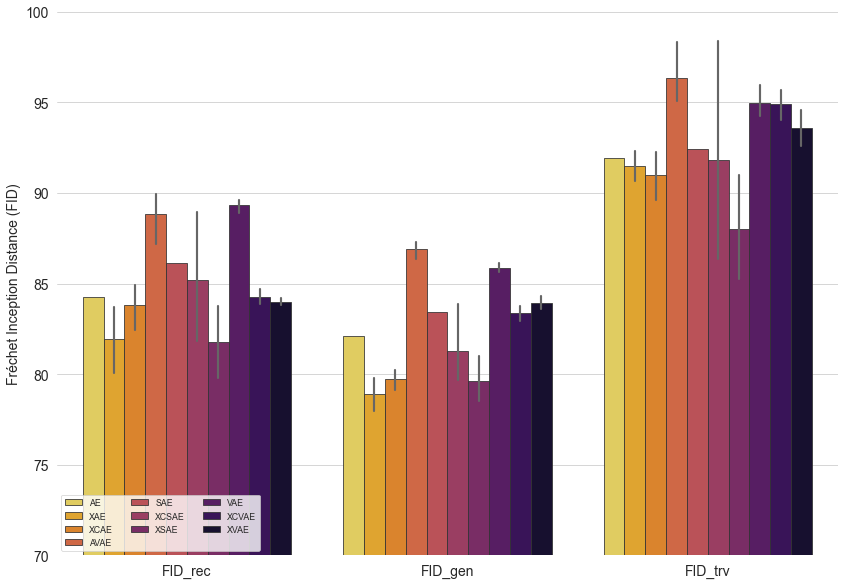

In [95]:
fig, ax = plt.subplots(figsize=(14,10))
palette="inferno_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
df = full_df2.sort_values(by=["model_family","model_name"])
ax = sns.barplot(x='variable',y="value", data=mdf,  
            palette=palette, hue="model_name", #hue_order=["AE","SAE","VAE"],
            ax=ax,  orient="v",errcolor=".4", edgecolor=".2")
ax.legend(ncol=3, loc="lower left", frameon=True)
ax.set(ylim=(70,100), ylabel="Fréchet Inception Distance (FID)",
       xlabel="")
sns.despine(left=True, bottom=True)

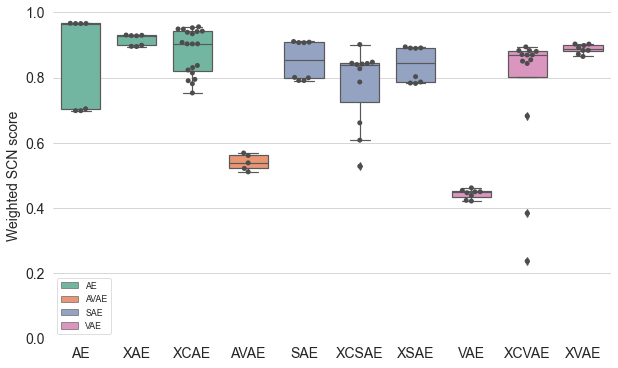

In [30]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium'})   
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
#df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E',
#                                                  'xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = full_df2.sort_values(by=["model_family","model_name"])
df = df.drop(df.loc[df['SCN+'].isna()].index)
df = df.drop(df.loc[df['model_name']=="CausalVAE"].index)
df = df.drop(df.loc[df['dataset']=="Pendulum"].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.boxplot(x='model_name',y="SCN_w", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.0,1.0))
sns.swarmplot(x='model_name',y="SCN_w", data=df, color=".3").set(xlabel=None, ylabel="Weighted SCN score")
ax.legend(ncol=1, loc="lower left", frameon=True)
sns.despine(left=True, bottom=True)

In [28]:
full_df2[["SCN+","model_name"]]

,SCN+,model_name
0,NaN,AE
1,NaN,VAE
2,NaN,SAE
3,NaN,XVAE
5,NaN,XVAE
...,...,...
122,0.703815,XSAE
123,0.736124,XAE
124,0.461378,XCSAE
125,0.729506,XCSAE


In [31]:
fname = fig_path / ("SCN_all_w.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")

Saving to figures\SCN_all_w.png


In [40]:
full_df2

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,model_family,model_type
0,AE,standardS_MNIST,MNIST,11.0,0.004052,0.089621,-64.377853,0.401517,NaN,0.709440,...,NaN,1.000000,0.756458,0.563324,0.564627,NaN,NaN,NaN,AE,N
1,VAE,standardS_MNIST,MNIST,11.0,0.001790,0.027738,-41.350979,0.187705,NaN,0.531160,...,NaN,1.000000,0.265083,0.292283,0.328937,NaN,NaN,NaN,VAE,N
2,SAE,standardS_MNIST,MNIST,11.0,0.002576,0.047337,-33.894054,0.225092,NaN,0.676901,...,NaN,1.000000,0.724167,0.490122,0.492243,NaN,NaN,NaN,SAE,N
3,XCVAE,standardS_MNIST,MNIST,17.0,0.003782,0.053704,-90.521759,0.448040,NaN,0.587642,...,0.873300,1.000000,0.500708,0.277719,0.403999,0.422916,0.435500,0.445675,VAE,XC
4,XCVAE,standardS_MNIST,MNIST,13.0,0.001469,0.013335,-55.546307,0.230211,NaN,0.565228,...,0.947800,1.000000,0.317875,0.200461,0.316065,0.158320,0.198817,0.251568,VAE,XC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,XCAE,conv_pd,Pendulum,11.0,0.004100,0.093998,-63.338112,0.855153,0.053809,0.884484,...,0.912400,0.948313,0.200187,0.020206,0.324635,0.000000,0.000000,0.000000,AE,XC
119,VAE,conv_pd,Pendulum,11.0,0.003748,0.044017,-24.513256,0.309212,0.106158,0.813553,...,NaN,1.000000,0.478250,0.112680,0.273103,0.366739,0.411888,0.317697,VAE,N
120,XVAE,conv_pd,Pendulum,11.0,0.001439,0.007410,-16.952648,0.165396,0.073438,0.938842,...,0.783525,1.000000,0.397250,0.097749,0.209000,0.191893,0.228741,0.253644,VAE,X
121,XCVAE,conv_pd,Pendulum,11.0,0.004842,0.144326,-30.659861,0.447413,0.030244,0.846020,...,0.689875,1.000000,0.556125,0.269174,0.413821,0.465300,0.451421,0.377673,VAE,XC


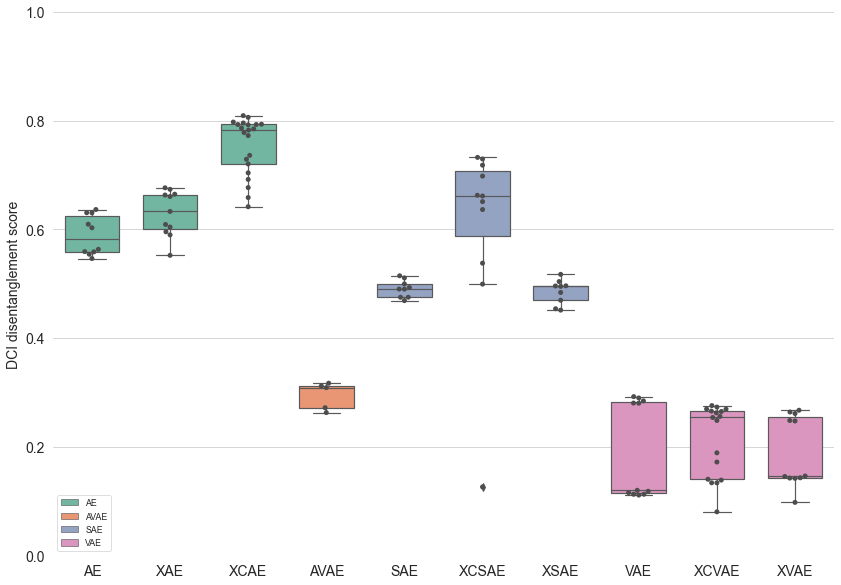

In [21]:
fig, ax = plt.subplots(figsize=(14,10))
#df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E',
#                                                  'xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = full_df2.sort_values(by=["model_family","model_name"])
df = df.drop(df.loc[df['DCIR_dis'].isna()].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.boxplot(x='model_name',y="DCIR_dis", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.0,1.0))
sns.swarmplot(x='model_name',y="DCIR_dis", data=df, color=".3").set(xlabel=None, ylabel="DCI disentanglement score")
ax.legend(ncol=1, loc="lower left", frameon=True)
sns.despine(left=True, bottom=True)

In [ ]:
# plotting the DCI scores and FIDs against INV/EQV scores

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=df2,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    height=5
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Snoot length (mm)", "Snoot depth (mm)")


In [17]:
full_df2.columns

Index(['model_name', 'model_version', 'dataset', 'random_seed', 'RBF', 'IMQ',
       'CAT', 'dCOV', 'DCI', 'IRS', 'MIG', 'ModExp', 'SAP', 'FID_rec',
       'FID_gen', 'FID_trv', 'INV', 'INV_w', 'EQV', 'EQV_w', 'sparsity', 'SCN',
       'SCN_w', 'inference', 'inferenceX', 'PLC', 'RLC', 'DCIR_dis',
       'DCIR_cmplt', 'model_family', 'model_type'],
      dtype='object')

Text(19.96, 0.5, 'Traversal FID')

<Figure size 864x864 with 0 Axes>

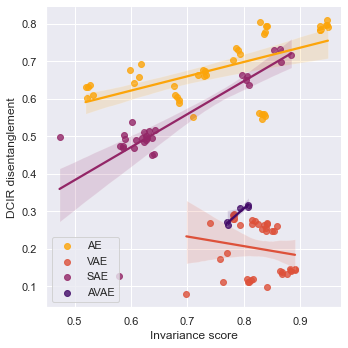

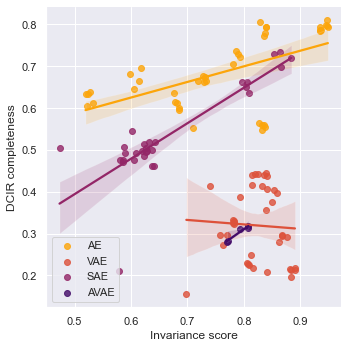

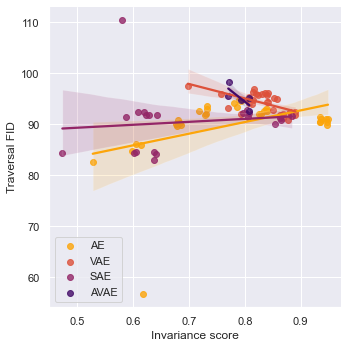

In [22]:
import seaborn as sns
%matplotlib inline
sns.axes_style("white")
sns.set_context("poster")
sns.set(rc={'figure.figsize':(12,12)})

sns.despine(offset=10, trim=True);
g1 = sns.lmplot(data=full_df2,x="INV", y="DCIR_dis", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='lower left')
plt.xlabel("Invariance score")
plt.ylabel("DCIR disentanglement")
g2 = sns.lmplot(data=full_df2,x="INV", y="DCIR_cmplt", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='lower left')
plt.xlabel("Invariance score")
plt.ylabel("DCIR completeness")
g3 = sns.lmplot(data=full_df2,x="INV", y="FID_trv", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='lower left')
plt.xlabel("Invariance score")
plt.ylabel("Traversal FID")

In [38]:
fname = fig_path / ("DCIR_dis_INV.png")
g1.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")
fname = fig_path / ("DCIR_cmplt_INV.png")
g2.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")
fname = fig_path / ("FID_trv_INV.png")
g3.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")

Saving to figures\DCIR_dis_INV.png
Saving to figures\DCIR_cmplt_INV.png
Saving to figures\FID_trv_INV.png


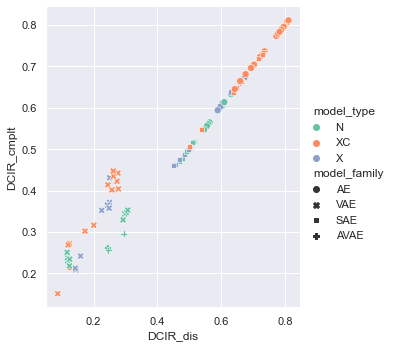

In [11]:
sns.set_theme()
sns.set_style("white")
sns.set(rc={'figure.figsize':(12,12)})
sns.relplot(data=full_df2, x="DCIR_dis", y="DCIR_cmplt", hue="model_type",
            style="model_family", kind="scatter", s=50, aspect=0.9, 
           palette='Set2')

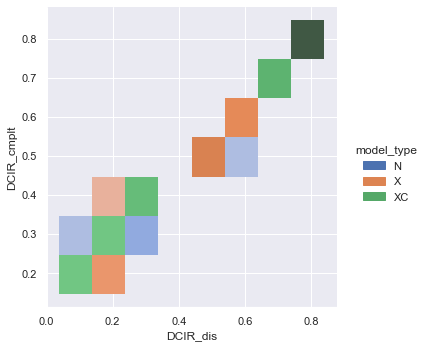

In [99]:
sns.displot(data=full_df2, x="DCIR_dis", y="DCIR_cmplt", hue="model_type",binwidth=(.1, .1))


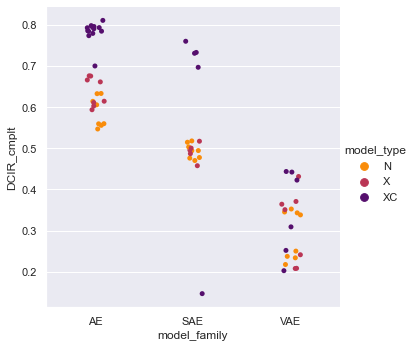

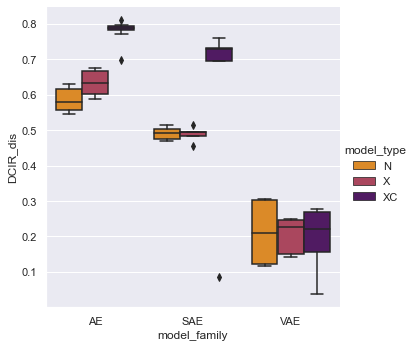

In [147]:
sns.catplot(data=full_df2, x="model_family", y="DCIR_cmplt", hue="model_type", kind="strip",palette='inferno_r')
sns.catplot(data=full_df2, x="model_family", y="DCIR_dis", hue="model_type", kind="box",palette='inferno_r')


In [30]:
df = full_df2.sort_values(by=["model_family","model_type"])
df1 = df[['model_type','model_family','model_name','model_version','DCIR_cmplt']].assign(DCIR=1).loc[df["dataset"]=="MNIST"]
df2 = df[['model_type','model_family','model_name','model_version','DCIR_dis']].assign(DCIR=2).loc[df["dataset"]=="MNIST"]
cdf = pd.concat([df1, df2])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['model_type',"model_family","model_name","DCIR"], value_vars=["DCIR_cmplt","DCIR_dis"])      # MELT

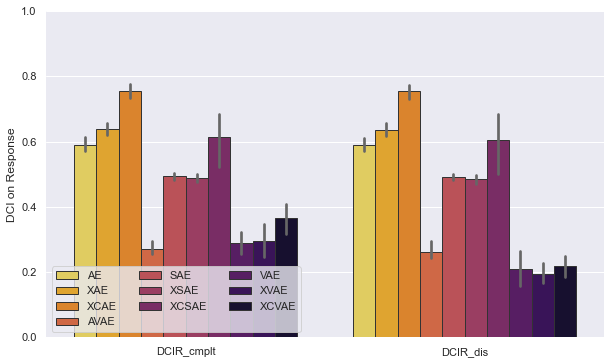

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
palette="inferno_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
df = full_df2.sort_values(by=["model_family","model_type"])
ax = sns.barplot(x='variable',y="value", data=mdf,  
            palette=palette, hue="model_name", #hue_order=["AE","SAE","VAE"],
            ax=ax,  orient="v",errcolor=".4", edgecolor=".2")
ax.legend(ncol=3, loc="lower left", frameon=True)
ax.set(ylim=(0,1), ylabel="DCI on Response",
       xlabel="")
sns.despine(left=True, bottom=True)

In [15]:
mdf

,model_type,model_family,model_name,DCIR,variable,value
0,N,AE,AE,1,DCIR_cmplt,0.564627
1,N,AE,AE,1,DCIR_cmplt,0.559369
2,N,AE,AE,1,DCIR_cmplt,0.560199
3,N,AE,AE,1,DCIR_cmplt,0.555747
4,N,AE,AE,1,DCIR_cmplt,0.547197
...,...,...,...,...,...,...
423,XC,VAE,XCVAE,2,DCIR_dis,0.257539
424,XC,VAE,XCVAE,2,DCIR_dis,0.262093
425,XC,VAE,XCVAE,2,DCIR_dis,0.261619
426,XC,VAE,XCVAE,2,DCIR_dis,0.124484


Text(0, 0.5, 'Model family')

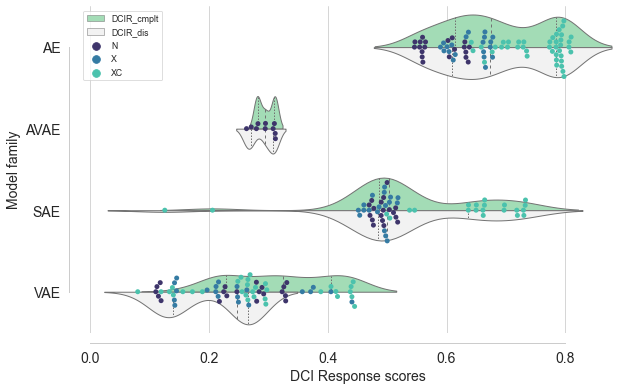

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='value',y="model_family", data=mdf, hue="variable", split=True, inner="quart", linewidth=1,
               palette={"DCIR_cmplt": (0.6,0.9,0.7),"DCIR_dis": ".95"}, bw=.4, ax=ax).set(xlabel=None, ylabel=None)
sns.swarmplot(x='value',y="model_family", hue="model_type",data=mdf,palette="mako").set(xlabel="DCI score (dis & cmplt)", ylabel="Model family")
sns.despine(offset=10, trim=True)
plt.legend(loc='upper left')
plt.xlabel("DCI Response scores")
plt.ylabel("Model family")

In [17]:

fname = fig_path / ("DCIxModels.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")

Saving to figures\DCIxModels.png


In [196]:
df = full_df2.copy()#.loc[full_df2['model_version'].isin(['xunit_dim4E','standardSE'])]
df = df.sort_values(by=["model_family","model_name"])
df['multidim'] = df['model_version'].apply(multidim)
df['XCnet'] = df['model_name'].apply(is_XCnet)
df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,inference,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,model_family,model_type,multidim,XCnet
0,AE,standardS,MNIST,13,0.003899,0.088719,-63.280827,0.396347,NaN,0.706463,...,0.9922,NaN,0.999833,0.766500,0.546041,0.546840,AE,N,Unidimensional,False
1,AE,standardS,MNIST,17,0.003942,0.089333,-63.330387,0.394834,NaN,0.707989,...,0.9843,NaN,1.000000,0.764625,0.558551,0.559718,AE,N,Unidimensional,False
2,AE,standardS,MNIST,37,0.003896,0.088461,-63.894592,0.399008,NaN,0.705150,...,0.9922,NaN,0.999958,0.769250,0.554719,0.555747,AE,N,Unidimensional,False
3,AE,standardS,MNIST,121,0.003989,0.089578,-63.826866,0.395914,NaN,0.709458,...,0.9843,NaN,0.998833,0.764625,0.558600,0.559386,AE,N,Unidimensional,False
44,AE,standard,MNIST,37,0.002746,0.005457,-27.061150,0.051587,NaN,0.545134,...,0.9688,NaN,0.987500,0.849521,0.630432,0.633055,AE,N,Unidimensional,False


In [211]:
df2 = df.sort_values(by=["model_family","model_type"])
df2_1 = df2[['model_type','model_family','model_name','model_version','DCIR_cmplt','XCnet']].assign(DCIR=1)
df2_2 = df2[['model_type','model_family','model_name','model_version','DCIR_dis','XCnet']].assign(DCIR=2)
cdf = pd.concat([df2_1, df2_2])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['model_type',"model_family","model_name","DCIR","XCnet"], value_vars=["DCIR_cmplt","DCIR_dis"])      # MELT

In [212]:
mdf.head()

,model_type,model_family,model_name,DCIR,XCnet,variable,value
0,N,AE,AE,1,False,DCIR_cmplt,0.546840
1,N,AE,AE,1,False,DCIR_cmplt,0.559718
2,N,AE,AE,1,False,DCIR_cmplt,0.555747
3,N,AE,AE,1,False,DCIR_cmplt,0.559386
4,N,AE,AE,1,False,DCIR_cmplt,0.633055


Text(426.93772507804493, 0.5, 'DCIR completeness')

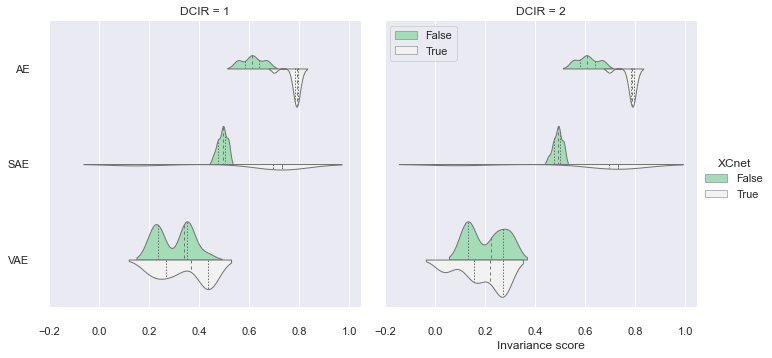

In [221]:
#fig, ax = plt.subplots(figsize=(10,6))
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.catplot(x='value',y="model_family", kind="violin",data=mdf, hue="XCnet", split=True, inner="quart", col="DCIR", linewidth=1,
               palette={False: (0.6,0.9,0.7), True: ".95"}, bw=.4).set(xlabel=None, ylabel=None)
#sns.swarmplot(x='value',y="model_family", hue="model_type",data=mdf,palette="mako").set(xlabel="DCI score (dis & cmplt)", ylabel="Model family")
sns.despine(offset=10, trim=True)
plt.legend(loc='upper left')
plt.xlabel("Invariance score")
plt.ylabel("DCIR completeness")

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='value',y="model_family", data=mdf, hue="DCIR", split=True, inner="quart", linewidth=1,
               palette={1: (0.6,0.9,0.7), 2: ".95"}, bw=.4).set(xlabel=None, ylabel=None)
sns.swarmplot(x='value',y="model_family", hue="model_type",data=mdf,palette="mako").set(xlabel="DCI score (dis & cmplt)", ylabel="Model family")
sns.despine(offset=10, trim=True)
plt.legend(loc='upper left')
plt.xlabel("Invariance score")
plt.ylabel("DCIR completeness")

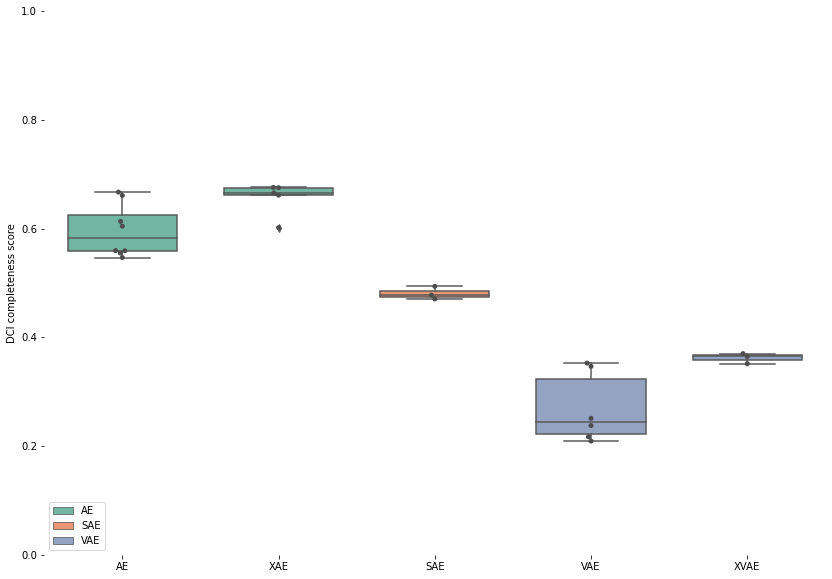

In [14]:
fig, ax = plt.subplots(figsize=(14,10))
#df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E',
#                                                  'xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = full_df2.sort_values(by=["model_family","model_name"])
df = df.drop(df.loc[df['DCIR_cmplt'].isna()].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.boxplot(x='model_name',y="DCIR_cmplt", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.0,1.0))
sns.swarmplot(x='model_name',y="DCIR_cmplt", data=df, color=".3").set(xlabel=None, ylabel="DCI completeness score")
ax.legend(ncol=1, loc="lower left", frameon=True)
sns.despine(left=True, bottom=True)

In [336]:

fname = fig_path / ("INV_scores.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\INV_scores.png


[Text(0, 0.5, ''), Text(0.5, 0, '')]

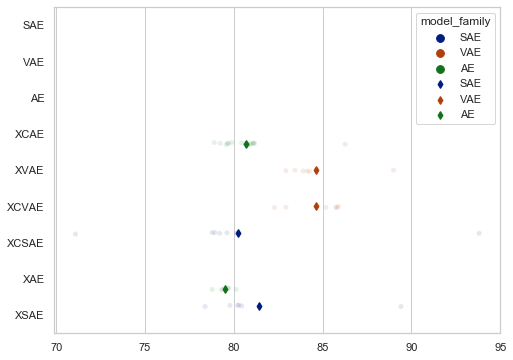

In [20]:
fig = plt.figure(figsize=(8,6))
df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE'])]
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="dark"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.stripplot(x='FID_trv',y="model_name", data=df,  
            palette=palette, hue="model_family", dodge=True, alpha=.1, zorder=2).set(xlabel=None, ylabel=None, xlim=None)
sns.pointplot(x='FID_trv',y="model_name", data=df, palette=palette, hue="model_family",
              markers="d", scale=.75, ci=None, dodge=.8 - .8 / 3,
              join=False).set(xlabel=None, ylabel=None)

In [34]:
fig = plt.figure(figsize=(8,6))
df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE'])]
df['Xnet'] = df['model_name'].apply(is_Xnet)
df['multidim'] = df['model_version'].apply(multidim)
df['XCnet'] = df['model_name'].apply(is_XCnet)
df = df.drop(df.loc[df['XCnet']==False].index)
df = df.drop(df.loc[df['IMQ'].isna()].index)
#df = df.drop(df.loc[df['model_name']=="AVAE"].index)
#sns.boxplot(x='INV',y="model_name", palette="Blues",data=df, width=2.0, hue="model_family").set(xlabel=None)
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='IMQ',y="model_family", data=df, hue="multidim", split=True, inner="quart", linewidth=1,
               palette={"Multidimensional": (0.6,0.9,0.7), "Unidimensional": ".95"}).set(xlabel=None, ylabel=None)
sns.despine(left=True)

ValueError: min() arg is an empty sequence

<Figure size 576x432 with 0 Axes>

No handles with labels found to put in legend.


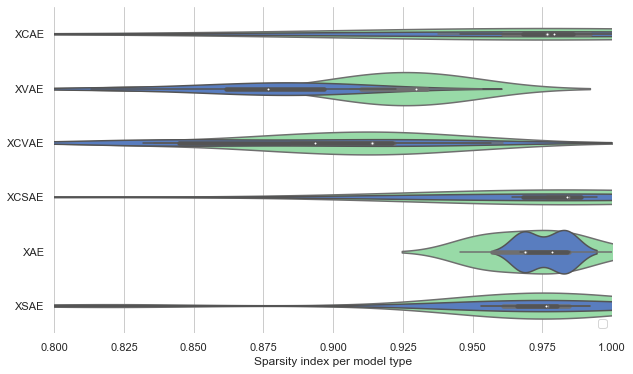

In [61]:

sns.set_context("poster", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 6))

df = full_df2.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = df.drop(df.loc[df['inferenceX'].isna()].index)
sns.set_color_codes("pastel")
sns.violinplot(x='inference',y="model_name", data=df, label="inference from N", dodge=False, 
            color="g").set(xlabel=None, ylabel=None, xlim=(0.8,1.0))
sns.set_color_codes("muted")
sns.violinplot(x='inferenceX',y="model_name", data=df, label="inference from Z", dodge=False, 
            color="b").set(xlabel=None, ylabel=None, xlim=(0.8,1.0))

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0.8,1.0), ylabel="",
       xlabel="Sparsity index per model type")
sns.despine(left=True, bottom=True)

[(0.7, 1.0), Text(0, 0.5, 'Average test accuracy'), Text(0.5, 0, '')]

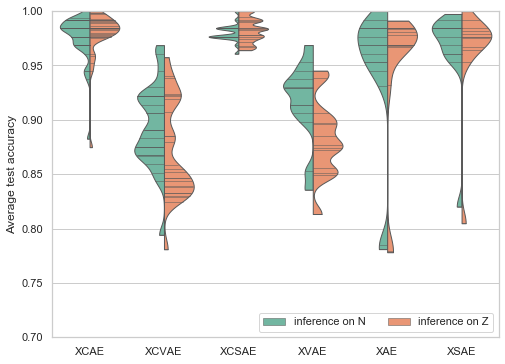

In [55]:

f, ax = plt.subplots(figsize=(8, 6))
df = full_df2#.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','xunit_dim7', 'standardSE', 'standard', 'standardE'])]
df = df.drop(df.loc[df['inferenceX'].isna()].index)
df_plot = df.melt(id_vars='model_name', value_vars=["inference", "inferenceX"])
def change_names(name):
    if name=="inference": return "inference on N"
    if name=="inferenceX": return "inference on Z"
df_plot['variable'] = df_plot['variable'].apply(change_names)
palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='model_name',y="value", hue='variable', data=df_plot, split=True, 
               cut=0.0, scale="width", inner="stick", linewidth=1,
               palette=palette, bw=.2).set(xlabel=None, ylabel=None, ylim=(0.7,1.0))
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0.7,1.0), xlabel="",
       ylabel="Average test accuracy")
#sns.swarmplot(x='value',y="model_name", hue='variable', dodge=True, data=df_plot, color=".3").set(xlabel=None, ylabel=None)

In [23]:

def XC_type(version_name):
    if 'E' in version_name: 
        return "equivariance"
    return "invariance"
def XCnet(name):
    if 'XC' in name:
        return "Consistency training"
    return "Standard training"

def multidim(name):
    if 'xunit_dim' in name:
        return "Multidimensional"
    return "Unidimensional"

In [527]:
df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,SCN_w,model_family,model_type,multidim
165,AE,standardS,MNIST,37.0,0.003975,0.089624,-63.172874,0.398186,NaN,0.706446,...,NaN,0.9922,0.833619,NaN,NaN,NaN,0.687115,AE,N,Unidimensional
166,AE,standardS,MNIST,17.0,0.003872,0.086816,-63.259392,0.393872,NaN,0.704463,...,NaN,0.9844,0.838509,NaN,NaN,NaN,0.704808,AE,N,Unidimensional
167,AE,standardS,MNIST,13.0,0.003912,0.087656,-63.358753,0.396296,NaN,0.703941,...,NaN,0.9844,0.836908,NaN,NaN,NaN,0.691824,AE,N,Unidimensional
168,AE,standardS,MNIST,121.0,0.003916,0.087945,-63.425961,0.393901,NaN,0.707785,...,NaN,0.9766,0.833336,NaN,NaN,NaN,0.688201,AE,N,Unidimensional
171,AE,standardS,MNIST,11.0,0.004981,0.115413,-66.567390,0.448716,NaN,0.728408,...,80.401451,0.9921,0.824769,NaN,NaN,NaN,0.624428,AE,N,Unidimensional


[(0.8652331233024597, 1.0043858885765078),
 Text(0, 0.5, 'Equivariance score (XC)'),
 Text(0.5, 0, '')]

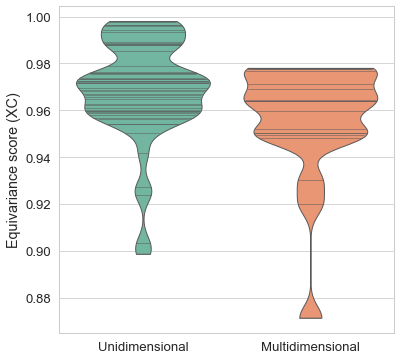

In [575]:


f, ax = plt.subplots(figsize=(6, 6))
df = full_df2.copy()#.loc[full_df2['model_version'].isin(['xunit_dim4E','standardSE'])]
df = df.sort_values(by=["model_family","model_name"])
df['multidim'] = df['model_version'].apply(multidim)
df['XCnet'] = df['model_name'].apply(is_XCnet)
df = df.drop(df.loc[df['XCnet']==False].index)
#df['XCtype'] = df['model_version'].apply(XC_type)
df = df.sort_values(by=["multidim"], ascending=False)

df = df.drop(df.loc[df['model_name']=="AVAE"].index)
df = df.drop(df.loc[df['dataset'].isin(["celeba"])].index)

palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='multidim',y="EQV", data=df, split=True, 
               cut=0.0, scale="width", inner="stick", linewidth=1,
               palette=palette, bw=.2)
#ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylim=None, xlabel="", ylabel="Equivariance score (XC)")
#sns.swarmplot(x='value',y="model_name", hue='variable', dodge=True, data=df_plot, color=".3").set(xlabel=None, ylabel=None)

[(0.23683336973190308, 0.9906766057014464),
 Text(0, 0.5, 'Invariance score'),
 Text(0.5, 0, '')]

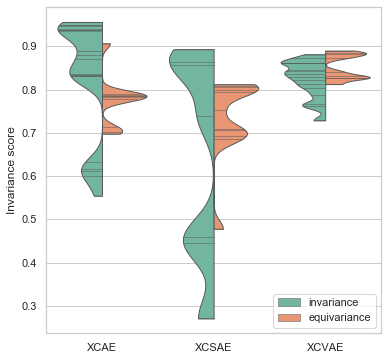

In [298]:

f, ax = plt.subplots(figsize=(6, 6))
df = full_df2.sort_values(by=["model_family","model_name"])

df = df#.loc[full_df2['model_version'].isin(['standardS','xunit_dim4','xunit_dim4E','standard','standardSE', 'standardE'])]
df['XCnet'] = df['model_name'].apply(is_XCnet)
df = df.drop(df.loc[df['XCnet']==False].index)
df = df.drop(df.loc[df['model_name']=="AVAE"].index)
df = df.drop(df.loc[df['dataset'].isin(["celeba"])].index)
df['XCtype'] = df['model_version'].apply(XC_type)
#df['XCnet'] = df['model_name'].apply(XCnet)

palette="Set2"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='model_name',y="INV", hue='XCtype', data=df, split=True, 
               cut=0.0, scale="width", inner="stick", linewidth=1,
               palette=palette, bw=.2)
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylim=None, xlabel="", ylabel="Invariance score")
#sns.swarmplot(x='value',y="model_name", hue='variable', dodge=True, data=df_plot, color=".3").set(xlabel=None, ylabel=None)

In [576]:

fname = fig_path / ("EQV_multidim_XC.png")
f.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\EQV_multidim_XC.png


In [43]:
df.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,EQV,SCN,FID_trv,inference,INV_w,EQV_w,inferenceX,sparsity,model_family,Xnet
3,XCSAE,standard,MNIST,11.0,0.001426,0.010699,-85.545578,0.133575,NaN,0.463532,...,137.217102,6.167468,NaN,NaN,NaN,NaN,NaN,NaN,SAE,True
19,XCAE,standardSE,MNIST,11.0,0.001849,0.018079,-35.558804,0.171073,NaN,0.677636,...,0.968723,5.571198,80.663075,0.9765,0.791295,0.969101,0.9843,NaN,AE,True
20,XVAE,standardS,MNIST,11.0,0.001587,0.011306,-43.764526,0.156623,NaN,0.598862,...,0.991257,3.292447,82.933933,0.8358,0.682406,0.985526,0.8134,NaN,VAE,True
21,XCVAE,standardSE,MNIST,11.0,0.001563,0.014160,-52.220730,0.219641,NaN,0.496950,...,0.989321,3.773677,82.936111,0.9218,0.737417,0.985190,0.9070,NaN,VAE,True
22,XCAE,standardS,MNIST,11.0,0.001860,0.022484,-42.722870,0.208227,NaN,0.635522,...,0.978832,5.641273,79.229177,0.9686,0.883969,0.979923,0.9750,NaN,AE,True


In [64]:
df.melt(id_vars='model_name', value_vars=["inference", "inferenceX"])

,model_name,variable,value
0,XCAE,inference,0.9765
1,XVAE,inference,0.8358
2,XCVAE,inference,0.9218
3,XCAE,inference,0.9686
4,XCSAE,inference,0.9766
...,...,...,...
147,XSAE,inferenceX,0.9818
148,XVAE,inferenceX,0.8507
149,XVAE,inferenceX,0.8744
150,XSAE,inferenceX,0.9843


In [227]:

fname = fig_path / ("FID_all2.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\FID_all2.png


In [ ]:
for k in full_df.columns[1:8]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='model_name',y=k,data=full_df,
                palette="Blues")

In [ ]:
for k in scores_df.columns[3:]: # orthogonality
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='data_version',y=k,data=scores_df, palette="Greens")

In [ ]:
# finally visualising 
for k in scores_df.columns[3:]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='model_name',y=k,data=scores_df, palette="Blues")

In [ ]:
# finally visualising 
for k in scores_df.columns[3:-1]: # disentanglement
    fig = plt.figure(figsize=(8,6))
    sns.boxplot(x='data_version',y=k,data=scores_df, palette="Greens")

# Invariance Scoring

In [501]:
model_names = ["AE","XAE","XCAE","BetaVAE","XVAE","XCVAE","BaseSAE","XSAE","XCSAE"]
model_names = ["XCAE"]
model_versions = ["StandardS","xunit_dim4"]
model_versions = ["xunit_dim4"]
i = 0
for model_name in model_names: 
    for v in model_versions: 
        if 'X' not in model_name and v in ["xunit_dim4","v32_x4_big"]: continue
        params = {"model_name":model_name,
                  "model_version":v,
                  "data" : "MNIST"}

        # load handler
        handler = ModelHandler.from_config(**params)
        handler.config["logging_params"]["save_dir"] = "./logs"
        handler.load_checkpoint('final')

configs/models/XCAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\xunit_dim4_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

In [114]:
model_name = "BetaVAE"
model_version = "standardS"
params = {"model_name":model_name,
          "model_version":model_version,
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

configs/models/BetaVAE/standardS.yaml
Initialising schedulers Manager...
Variational mode ON
BetaVAE model handler loaded.
Loading selected checkpoint at logs\BetaVAE\standardS_MNIST\checkpoints/final.ckpt
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        Max

In [115]:
params= {
    'intervention_type':'noise',
    'num_interventions':100, 
    'num_samples':200,
    'store':True, 
    'load':True, # note: when load=True the std_devs and intv_mags are not returned
    'random_seed':23,
    'num_batches':10,
    'mode':'X',
    'normalise':False,
    'verbose':True}

#invariance_matrix, std_devs = handler.evaluate_invariance(**params)
invariance_matrix = handler.evaluate_invariance(**params)

Scoring model's response map invariance to noise interventions.
Loading invariances matrix


In [116]:
#invariance_matrix, std_devs = invariance_matrix
invariance_matrix

tensor([[0.1470, 0.8312, 0.9973, 0.8342, 0.8105, 0.9987],
        [0.9143, 0.3289, 0.9981, 0.8910, 0.8901, 0.9977],
        [0.9972, 0.9959, 1.0000, 0.9969, 0.9974, 1.0000],
        [0.8974, 0.8377, 0.9971, 0.1478, 0.7942, 0.9985],
        [0.9309, 0.9174, 0.9983, 0.9181, 0.3769, 0.9992],
        [0.9974, 0.9953, 1.0000, 0.9965, 0.9963, 1.0000]], device='cuda:0')

In [117]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,8), "nrows":3, "N":100, "markersize":10, "font_scale":10, "cbar":False}

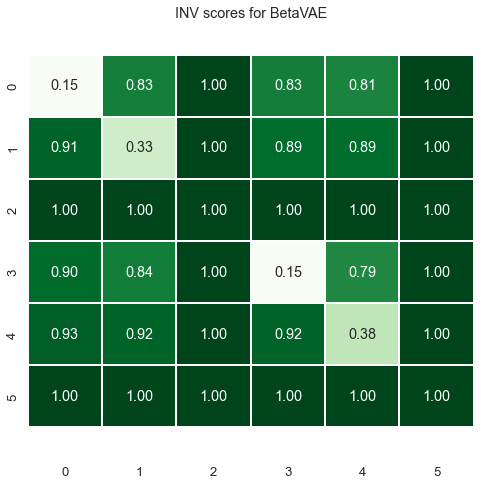

In [118]:
fig = handler.visualiser.plot_heatmap(invariance_matrix.cpu(), 
                                      title="INV scores for "+model_name, 
                                      threshold=0., 
                                      **figure_params)
#fig2 = handler.visualiser.plot_heatmap(std_devs.view(2,6).cpu(), 
#                                      title="Standard Deviation of marginals (original and responses)", 
#                                      threshold=0., figsize=(8,2))

In [119]:

fname = fig_path / ("inv_mat_"+model_name+"_"+model_version+".png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\inv_mat_BetaVAE_standardS.png


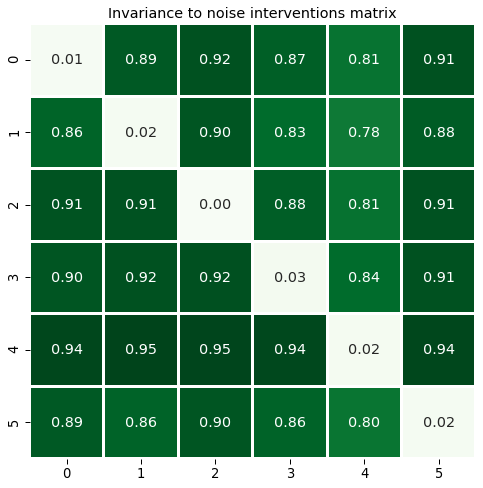

In [34]:

fname2 = fig_path / ("std_devs_"+model_name+"_E"+".png")
fig2.savefig(fname2, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname2}")

In [46]:
print(torch.sum(invariance_matrix.cpu()*(1-torch.eye(6))))

tensor(25.1000)


In [ ]:
torch.sum((((1. - invariance_matrix.cpu())*torch.eye(6)) + invariance_matrix.cpu()*(1-torch.eye(6))))

# Equivariance

In [479]:
model_name = "XCAE"
model_version = "standardSE"
params = {"model_name":model_name,
          "model_version":model_version,
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

configs/models/XCAE/standardSE.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\standardSE_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

In [480]:
params= {
    'intervention_type':'noise',
    'num_interventions':100, 
    'num_samples':100,
    'store':True, 
    'load':True, # note: when load=True the std_devs and intv_mags are not returned
    'random_seed':23,
    'num_batches':10,
    'mode':'X',
    'prior_mode':'posterior',
    'normalise':True,
    'verbose':True}

equivariance_matrix = handler.evaluate_equivariance(**params)

Scoring model's response map equivariance to noise interventions.
Loading equivariance matrix


In [481]:
sd_dev

NameError: name 'sd_dev' is not defined

In [ ]:
#equivariance_matrix, std_dev = equivariance_matrix
equivariance_matrix

In [482]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,8), "nrows":3, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

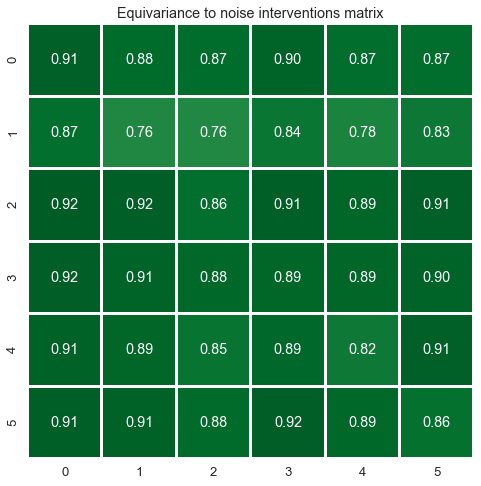

In [483]:
fig = handler.visualiser.plot_heatmap(equivariance_matrix.cpu(), 
                                      title="Equivariance to noise interventions matrix", 
                                      threshold=0., 
                                      **figure_params)

In [484]:
print(torch.sum(equivariance_matrix[:,:2])+torch.sum(equivariance_matrix[:,3:]))

tensor(26.4915, device='cuda:0')


In [485]:
fname = fig_path / ("eqv_mat_"+model_name+"_"+model_version+".png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")

Saving to figures\eqv_mat_XCAE_standardSE.png


# Self-consistency

configs/models/XCVAE/standardS.yaml
Initialising schedulers Manager...
Variational mode ON
Causal mode ON
Explicit mode ON
XCVAE model handler loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCVAE\standardS_MNIST\checkpoints/final.ckpt
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1

0it [00:00, ?it/s]

Saving to figures\SCN_XCVAE_standardS.png


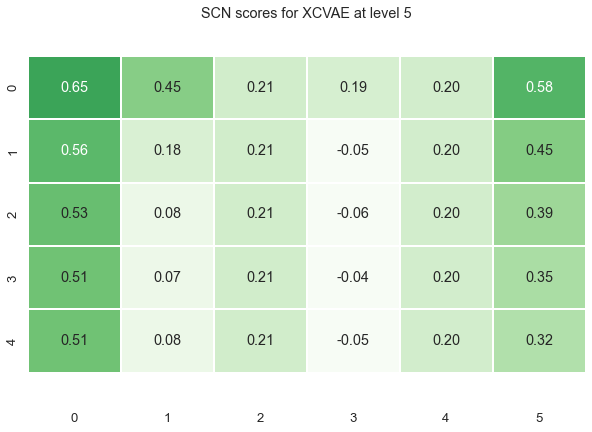

In [123]:
model_name="XCVAE"
params = {"model_name":model_name,
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
handler.reset_tau(100000)
prior_mode="posterior"
level=5
params= {'num_samples':1000,
        'random_seed':23,
        'num_batches':10,
        'prior_mode':prior_mode,
        'normalise': False,
        'verbose':True, 
        'level':level}

with torch.no_grad():
    consistency, std_dev = handler.evaluate_self_consistency(**params)
fig = handler.visualiser.plot_heatmap(consistency.view(level,-1).cpu(), 
                              title="SCN scores for "+model_name+" at level "+str(level), 
                              threshold=0., 
                              **figure_params)
del handler
figure_params = {"figsize":(10,level+2), "nrows":6, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}
fname = fig_path / ("SCN_"+model_name+"_"+"standardS"+".png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


In [168]:
all_consistencies = torch.vstack(all_consistencies)

In [169]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])

In [170]:
figure_params = {"figsize":(8,2), "nrows":6, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

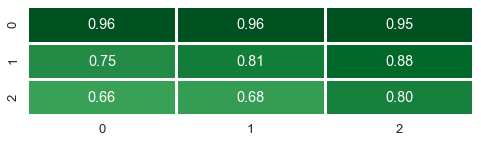

In [171]:
fig = handler.visualiser.plot_heatmap(all_consistencies.T.view(3,-1).cpu(), 
                                      title="", 
                                      threshold=0., 
                                      **figure_params)

In [ ]:
fig2 = handler.visualiser.plot_heatmap(std_dev.view(2,6).cpu(), 
                                      title="Standard Deviation of marginals (original and responses)", 
                                      threshold=0., figsize=(8,2))

In [172]:

fname = fig_path / ("all_SCN.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")


Saving to figures\all_SCN.png


## Entropy of causal dimensions

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"multidim",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()
handler.reset_tau(100000)

In [ ]:
params= {'num_batches':10}

entropies = handler.score_causal_vars_entropy(**params)

In [ ]:
entropies

In [ ]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(handler.model.latent_size+2,2), "nrows":1, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

In [ ]:
fig = handler.visualiser.plot_heatmap(entropies.view(1,-1).cpu(), 
                                      title="Entropies", 
                                      threshold=0., 
                                      **figure_params)

In [486]:
# collecting entropy for all the XCAE standardS model to compare 
all_entropies = []
model_versions = ["standardS","multidim"]+[f"xunit_dim{i}" for i in range(3,8)]
params = {"model_name":"XCAE", "model_version":"multidim", "data" : "MNIST"}
eparams= {'num_batches':10}
for v in model_versions: 
    # load model
    params["model_version"] = v
    handler = ModelHandler.from_config(**params)
    handler.config["logging_params"]["save_dir"] = "./logs"
    handler.load_checkpoint()
    handler.reset_tau(100000)
    # computing the entropies
    entropies = handler.score_causal_vars_entropy(**eparams)
    all_entropies.append(entropies)

configs/models/XCAE/standardS.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\standardS_MNIST\checkpoints\epoch=290-step=94911.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1

configs/models/XCAE/multidim.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\multidim_MNIST\checkpoints\epoch=181-step=59490.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 

configs/models/XCAE/xunit_dim3.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim3_MNIST\checkpoints\epoch=203-step=66863.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [

configs/models/XCAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim4_MNIST\checkpoints\epoch=276-step=90860.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [

configs/models/XCAE/xunit_dim5.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim5_MNIST\checkpoints\final.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

configs/models/XCAE/xunit_dim6.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim6_MNIST\checkpoints\epoch=94-step=31125.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-

configs/models/XCAE/xunit_dim7.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading latest checkpoint at logs\XCAE\xunit_dim7_MNIST\checkpoints\epoch=196-step=64358.ckpt .
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [

In [487]:
_all_entropies = torch.vstack([all_entropies[0]]+all_entropies[2:]) # removing multidim
_all_entropies

tensor([[ 0.8884,  0.7885,  0.7482,  1.0801,  0.8263,  0.8981],
        [-0.0627,  0.6248, -0.7576,  0.5387,  0.4209,  1.6064],
        [ 0.6159,  0.1816,  1.1932,  1.3506,  2.0028,  2.9957],
        [ 0.5277,  0.0081,  0.1812, -0.3004, -1.0618,  1.3993],
        [ 1.3360,  0.9825,  0.5867,  3.4153,  3.0329,  4.2631],
        [ 2.5604,  2.0047,  2.7364,  2.8637,  2.3942,  4.4290]],
       device='cuda:0')

In [490]:
total = torch.sum(_all_entropies, dim=1)
total

tensor([ 5.2296,  2.3705,  8.3397,  0.7542, 13.6165, 16.9885], device='cuda:0')

In [493]:
x = [1] + list(range(3,8))
x

[1, 3, 4, 5, 6, 7]

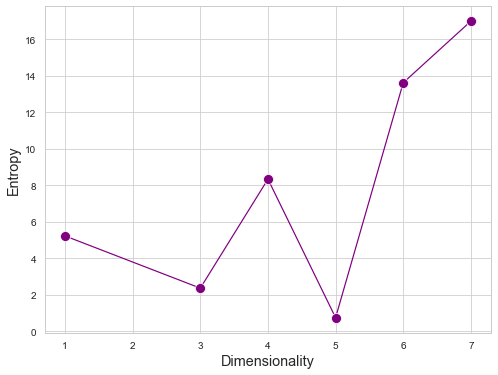

In [494]:
ylim = None; xlim=None; figsize=(8,6)
fig = plt.figure(figsize=figsize)
axi = sns.lineplot(x = x, y=total.cpu().numpy(), marker="o", markersize=10, color="purple")
axi.set(ylabel='Entropy', xlabel='Dimensionality')
axi.tick_params(axis="x", labelsize=10)
axi.tick_params(axis="y", labelsize=10)
if ylim is not None: axi.set(ylim=(0, ylim))
if xlim is not None: axi.set(xlim=(-xlim, xlim))

In [495]:
# looking at the other scores on the same models
_all_scores = []
scores = ["FID_rec","FID_gen","EQV","INV","SCN"]
model_versions = ["standardS_MNIST"]+[f"xunit_dim{i}_MNIST" for i in range(3,8)]
for s in scores: 
    s_scores = []
    for v in model_versions: 
        s_scores.append(full_df.loc[full_df["model_version"] == v].loc[full_df["model_name"] == "XCAE"][s].item())
    _all_scores.append(s_scores)

c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [496]:
all_scores = torch.vstack([total.cpu(),torch.Tensor(_all_scores)])

In [497]:
x = [1] + list(range(3,8))
x = x*len(all_scores)

In [498]:
hue = [i for i in ['entropy']+scores for _ in range(6)]
hue

['entropy',
 'entropy',
 'entropy',
 'entropy',
 'entropy',
 'entropy',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_rec',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'FID_gen',
 'EQV',
 'EQV',
 'EQV',
 'EQV',
 'EQV',
 'EQV',
 'INV',
 'INV',
 'INV',
 'INV',
 'INV',
 'INV',
 'SCN',
 'SCN',
 'SCN',
 'SCN',
 'SCN',
 'SCN']

In [499]:

import matplotlib.ticker as ticker

<Figure size 432x288 with 0 Axes>

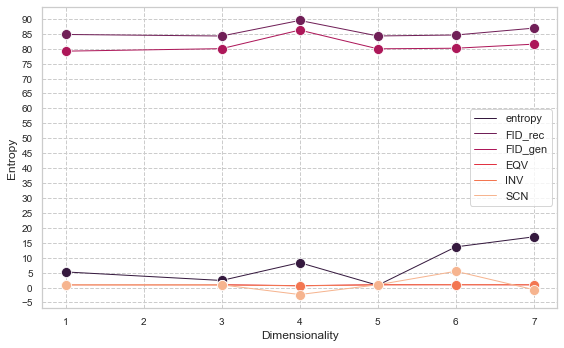

In [500]:
with sns.axes_style("whitegrid",  {'grid.linestyle': '--'}):
    sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.0})
    sns.despine(left=True)
    ylim = None; xlim=None; figsize=(8,5)
    fig = plt.figure(figsize=figsize)
    axi = sns.lineplot(x = x, y=all_scores.view(-1,).numpy(), marker="o", hue = hue, markersize=10, palette="rocket")
    axi.set(ylabel='Entropy', xlabel='Dimensionality')
    axi.tick_params(axis="x", labelsize=10)
    axi.tick_params(axis="y", labelsize=10)
    axi.yaxis.set_major_locator(ticker.MultipleLocator(5))
    if ylim is not None: axi.set(ylim=(0, ylim))
    if xlim is not None: axi.set(xlim=(-xlim, xlim))
    fig.tight_layout()

## Inference score

In [33]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

configs/models/XCAE/standardS.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\standardS_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]  

In [37]:
params= {'causal':False,
         'num_train':20000,
         'num_test':1000}

importance_matrix, train_acc, test_acc = handler.evaluate_inference(**params)

Starting training inference model...
Training complete in 0m 19s
Average test Acc: 0.969000


In [35]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])

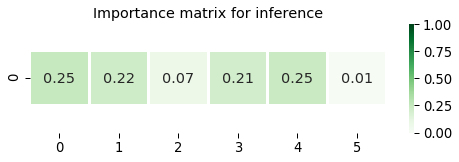

In [36]:
figure_params = {"figsize":(8,2), "nrows":6, "font_scale":10, "vmin":0.0, "vmax":1.0}
_ = handler.visualiser.plot_heatmap(torch.Tensor(importance_matrix).view(1,6), 
                        title="Importance matrix for inference", threshold=0., **figure_params)

## Table of invariance and equivariance

In [45]:
full_df2.head()

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,inferenceX,PLC,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,model_family,model_type
0,AE,standardS_MNIST,MNIST,11.0,0.004052,0.089621,-64.377853,0.401517,NaN,0.709440,...,NaN,1.0,0.756458,0.563324,0.564627,NaN,NaN,NaN,AE,N
1,VAE,standardS_MNIST,MNIST,11.0,0.001790,0.027738,-41.350979,0.187705,NaN,0.531160,...,NaN,1.0,0.265083,0.292283,0.328937,NaN,NaN,NaN,VAE,N
2,SAE,standardS_MNIST,MNIST,11.0,0.002576,0.047337,-33.894054,0.225092,NaN,0.676901,...,NaN,1.0,0.724167,0.490122,0.492243,NaN,NaN,NaN,SAE,N
3,XCVAE,standardS_MNIST,MNIST,17.0,0.003782,0.053704,-90.521759,0.448040,NaN,0.587642,...,0.8733,1.0,0.500708,0.277719,0.403999,0.422916,0.435500,0.445675,VAE,XC
4,XCVAE,standardS_MNIST,MNIST,13.0,0.001469,0.013335,-55.546307,0.230211,NaN,0.565228,...,0.9478,1.0,0.317875,0.200461,0.316065,0.158320,0.198817,0.251568,VAE,XC


In [59]:
IC_df = full_df2[["model_family","model_type","dataset","INV","EQV","FID_trv","FID_gen"]]
IC_df

,model_family,model_type,dataset,INV,EQV,FID_trv,FID_gen
0,AE,N,MNIST,0.826321,NaN,91.914868,82.130910
1,VAE,N,MNIST,0.783396,NaN,NaN,NaN
2,SAE,N,MNIST,0.608633,NaN,92.451548,83.407869
3,VAE,XC,MNIST,0.793590,0.970875,91.912294,82.135719
4,VAE,XC,MNIST,0.770207,0.967108,93.247039,82.381669
...,...,...,...,...,...,...,...
115,VAE,XC,MNIST,0.868103,0.996609,91.981758,81.942208
117,AE,X,Pendulum,0.710332,0.909542,NaN,NaN
119,VAE,N,Pendulum,0.763712,NaN,NaN,NaN
120,VAE,X,Pendulum,0.840817,0.990667,NaN,NaN


In [60]:
IC_df['XCnet'] = IC_df['model_type'].apply(is_XCnet)
IC_df

C:\Users\Giulia\miniconda3\envs\SAE\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,model_family,model_type,dataset,INV,EQV,FID_trv,FID_gen,XCnet
0,AE,N,MNIST,0.826321,NaN,91.914868,82.130910,False
1,VAE,N,MNIST,0.783396,NaN,NaN,NaN,False
2,SAE,N,MNIST,0.608633,NaN,92.451548,83.407869,False
3,VAE,XC,MNIST,0.793590,0.970875,91.912294,82.135719,True
4,VAE,XC,MNIST,0.770207,0.967108,93.247039,82.381669,True
...,...,...,...,...,...,...,...,...
115,VAE,XC,MNIST,0.868103,0.996609,91.981758,81.942208,True
117,AE,X,Pendulum,0.710332,0.909542,NaN,NaN,False
119,VAE,N,Pendulum,0.763712,NaN,NaN,NaN,False
120,VAE,X,Pendulum,0.840817,0.990667,NaN,NaN,False


In [61]:
res = IC_df.groupby(by=["model_family","XCnet"], as_index=False).agg({'INV':['mean','std'],'FID_trv':['mean','std'],'FID_gen':['mean','std']})
res

model_family  XCnet       INV              FID_trv               FID_gen  \
                           mean       std       mean        std       mean   
0           AE  False  0.692870  0.110951  90.688256   2.879765  78.853536   
1           AE   True  0.823690  0.122922  90.852987   3.022260  79.596507   
2         AVAE  False  0.783283  0.020651  96.340896   1.759104  86.818035   
3          SAE  False  0.615746  0.021266  88.794262   4.100966  80.175758   
4          SAE   True  0.757864  0.139198  88.227075  14.534882  77.512535   
5          VAE  False  0.828276  0.040824  93.932021   1.680843  84.459313   
6          VAE   True  0.809034  0.048850  94.723057   1.909621  83.227241   

              
         std  
0   1.648692  
1   1.348699  
2   0.483683  
3   2.185607  
4  13.268746  
5   1.093494  
6   0.776013

In [36]:
res.sort_values(by='model_family')

model_family  XCnet       INV              FID_trv               FID_gen  \
                           mean       std       mean        std       mean   
0           AE  False  0.691997  0.113759  90.688256   2.879765  78.853536   
1           AE   True  0.823690  0.122922  90.852987   3.022260  79.596507   
2         AVAE  False  0.783283  0.020651  96.340896   1.759104  86.818035   
3          SAE  False  0.615746  0.021266  88.794262   4.100966  80.175758   
4          SAE   True  0.757864  0.139198  88.227075  14.534882  77.512535   
5          VAE  False  0.830877  0.040091  93.932021   1.680843  84.459313   
6          VAE   True  0.814001  0.046597  94.723057   1.909621  83.227241   

              
         std  
0   1.648692  
1   1.348699  
2   0.483683  
3   2.185607  
4  13.268746  
5   1.093494  
6   0.776013

In [25]:
## DCI scores table
DCI_df = full_df2[["model_name","model_version","dataset","INV","DCIR_cmplt","DCIR_dis"]]
DCI_df

,model_name,model_version,dataset,INV,DCIR_cmplt,DCIR_dis
0,AE,standardS,MNIST,0.826321,0.564627,0.563324
1,VAE,standardS,MNIST,0.783396,0.328937,0.292283
2,SAE,standardS,MNIST,0.608633,0.492243,0.490122
3,XCVAE,standardS,MNIST,0.793590,0.403999,0.277719
4,XCVAE,standardS,MNIST,0.770207,0.316065,0.200461
...,...,...,...,...,...,...
111,XCSAE,standard,MNIST,0.473457,0.505181,0.499715
112,XCAE,standard,MNIST,0.605531,0.645261,0.642307
113,XCAE,standard,MNIST,0.597649,0.681239,0.676143
114,XCSAE,standard,MNIST,0.601147,0.546480,0.537975


In [26]:
res = DCI_df.groupby(by=["model_name","dataset"], as_index=False).agg({'INV':['mean','std'],'DCIR_cmplt':['mean','std'], "DCIR_dis":['mean','std']})
res.sort_values(by=(       'INV', 'mean'))

model_name dataset       INV           DCIR_cmplt            DCIR_dis  \
                          mean       std       mean       std      mean   
2        SAE   MNIST  0.606653  0.021038   0.493391  0.016771  0.491000   
8       XSAE   MNIST  0.624838  0.018232   0.488805  0.019645  0.484826   
0         AE   MNIST  0.679269  0.162225   0.590902  0.036848  0.589123   
4        XAE   MNIST  0.704725  0.025360   0.639827  0.031943  0.636741   
6      XCSAE   MNIST  0.757864  0.139198   0.614294  0.151389  0.604469   
1       AVAE   MNIST  0.783283  0.020651   0.271115  0.021239  0.261257   
3        VAE   MNIST  0.796390  0.015501   0.288763  0.058449  0.210268   
7      XCVAE   MNIST  0.814001  0.046597   0.365711  0.089406  0.219692   
5       XCAE   MNIST  0.823690  0.122922   0.755476  0.050986  0.754128   
9       XVAE   MNIST  0.865364  0.022579   0.295877  0.086825  0.194988   

             
        std  
2  0.015688  
8  0.022171  
0  0.036156  
4  0.034406  
6  0.175916  
1  0.029238  
3  0.094850  
7  0.066282  
5  0.052302  
9  0.051606

## SCN scores

In [35]:
full_df2.columns

Index(['model_name', 'model_version', 'dataset', 'random_seed', 'RBF', 'IMQ',
       'CAT', 'dCOV', 'DCI', 'IRS', 'MIG', 'ModExp', 'SAP', 'FID_rec',
       'FID_gen', 'FID_trv', 'INV', 'INV_w', 'EQV', 'EQV_w', 'sparsity', 'SCN',
       'SCN_w', 'inference', 'inferenceX', 'PLC', 'RLC', 'DCIR_dis',
       'DCIR_cmplt', 'SCN_posterior', 'SCN_hybrid', 'SCN_uniform', 'SCN+',
       'model_family', 'model_type'],
      dtype='object')

In [36]:
df_SCN = full_df2[["model_name","model_family","model_type","SCN_posterior","SCN_hybrid","SCN_uniform"]].dropna() #8 nan
df_SCN

,model_name,model_family,model_type,SCN_posterior,SCN_hybrid,SCN_uniform
3,XVAE,VAE,X,0.436687,0.433629,0.441381
5,XVAE,VAE,X,0.438948,0.428877,0.435307
6,XAE,AE,X,0.957662,0.850308,0.712499
7,XSAE,SAE,X,0.956628,0.729223,0.290482
8,AE,AE,N,0.927808,0.822181,0.709186
...,...,...,...,...,...,...
122,XSAE,SAE,X,0.917807,0.715190,0.571863
123,XAE,AE,X,0.921161,0.797397,0.713562
124,XCSAE,SAE,XC,0.907231,0.733079,0.520735
125,XCSAE,SAE,XC,0.918642,0.730876,0.445844


In [29]:
df_SCN['Xnet'] = df_SCN['model_type'].apply(is_Xnet)
df_SCN

,model_name,model_family,model_type,SCN_posterior,SCN_hybrid,SCN_uniform,Xnet
3,XCVAE,VAE,XC,0.422916,0.435500,0.445675,True
4,XCVAE,VAE,XC,0.158320,0.198817,0.251568,True
7,XCVAE,VAE,XC,0.028496,0.046325,0.124802,True
8,XSAE,SAE,X,0.960342,0.761573,0.209413,True
9,AE,AE,N,0.967019,0.781424,0.754625,False
...,...,...,...,...,...,...,...
111,XCSAE,SAE,XC,0.918777,0.730560,0.445997,True
112,XCAE,AE,XC,0.917031,0.840446,0.716753,True
113,XCAE,AE,XC,0.917048,0.842372,0.711118,True
114,XCSAE,SAE,XC,0.908501,0.735552,0.520984,True


In [30]:
res = df_SCN.groupby(by=["model_name","model_type"], as_index=False).agg({'SCN_posterior':['mean','std'],'SCN_hybrid':['mean','std'], "SCN_uniform":['mean','std']})
res.sort_values(by=('SCN_hybrid','mean'))

model_name model_type SCN_posterior           SCN_hybrid            \
                                 mean       std       mean       std   
3        VAE          N      0.000000  0.000000   0.000213  0.000511   
1       AVAE          N      0.208453  0.023283   0.229882  0.034831   
9       XVAE          X      0.328155  0.112447   0.324579  0.109201   
7      XCVAE         XC      0.330345  0.138067   0.341273  0.135761   
2        SAE          N      0.944882  0.018455   0.731373  0.012851   
8       XSAE          X      0.940557  0.019135   0.732673  0.026407   
6      XCSAE         XC      0.900683  0.151185   0.778848  0.177791   
0         AE          N      0.947525  0.018956   0.806577  0.024467   
4        XAE          X      0.938288  0.020241   0.831115  0.025794   
5       XCAE         XC      0.940428  0.017363   0.882802  0.025789   

  SCN_uniform            
         mean       std  
3    0.000000  0.000000  
1    0.149319  0.018572  
9    0.330156  0.111095  
7    0.355830  0.110333  
2    0.477082  0.126082  
8    0.382563  0.175008  
6    0.500637  0.131330  
0    0.729739  0.019372  
4    0.702217  0.019735  
5    0.797982  0.049862

In [31]:
df_SCN.head()

,model_name,model_family,model_type,SCN_posterior,SCN_hybrid,SCN_uniform,Xnet
3,XCVAE,VAE,XC,0.422916,0.435500,0.445675,True
4,XCVAE,VAE,XC,0.158320,0.198817,0.251568,True
7,XCVAE,VAE,XC,0.028496,0.046325,0.124802,True
8,XSAE,SAE,X,0.960342,0.761573,0.209413,True
9,AE,AE,N,0.967019,0.781424,0.754625,False


Text(0, 0.5, 'Model family')

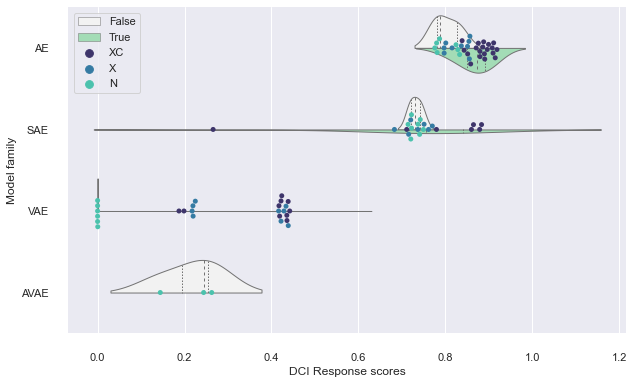

In [108]:
fig, ax = plt.subplots(figsize=(10,6))
palette="BuGn_r"#sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.violinplot(x='SCN_hybrid',y="model_family", data=df_SCN, hue="Xnet", split=True, inner="quart", linewidth=1,
               palette={True: (0.6,0.9,0.7),False: ".95"}, bw=.9, ax=ax).set(xlabel=None, ylabel=None)
sns.swarmplot(x='SCN_hybrid',y="model_family", hue="model_type",data=df_SCN,palette="mako").set(xlabel="DCI score (dis & cmplt)", ylabel="Model family")
sns.despine(offset=10, trim=True)
plt.legend(loc='upper left')
plt.xlabel("DCI Response scores")
plt.ylabel("Model family")

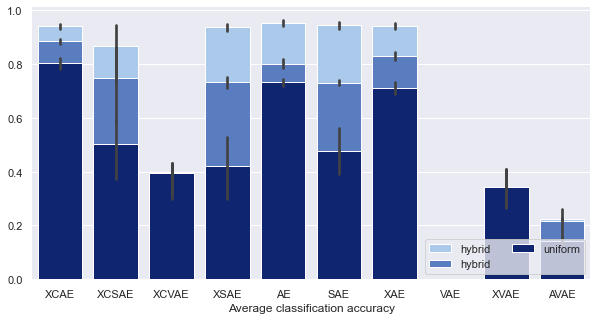

In [109]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

sns.set_color_codes("pastel")
sns.barplot(x="model_name", y="SCN_posterior", data=df_SCN,
            label="hybrid", color="b")

# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(x="model_name", y="SCN_hybrid", data=df_SCN,
            label="hybrid", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("dark")
sns.barplot(x="model_name", y="SCN_uniform", data=df_SCN,
            label="uniform", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Average classification accuracy")
sns.despine(left=True, bottom=True)

In [32]:
df_SCN["delta"] = df_SCN["SCN_posterior"] - df_SCN["SCN_hybrid"]
df_SCN["delta+"] = df_SCN["SCN_posterior"] - df_SCN["SCN_uniform"]
df_SCN

,model_name,model_family,model_type,SCN_posterior,SCN_hybrid,SCN_uniform,Xnet,delta,delta+
3,XCVAE,VAE,XC,0.422916,0.435500,0.445675,True,-0.012584,-0.022759
4,XCVAE,VAE,XC,0.158320,0.198817,0.251568,True,-0.040497,-0.093248
7,XCVAE,VAE,XC,0.028496,0.046325,0.124802,True,-0.017829,-0.096307
8,XSAE,SAE,X,0.960342,0.761573,0.209413,True,0.198769,0.750929
9,AE,AE,N,0.967019,0.781424,0.754625,False,0.185595,0.212394
...,...,...,...,...,...,...,...,...,...
111,XCSAE,SAE,XC,0.918777,0.730560,0.445997,True,0.188217,0.472780
112,XCAE,AE,XC,0.917031,0.840446,0.716753,True,0.076585,0.200278
113,XCAE,AE,XC,0.917048,0.842372,0.711118,True,0.074677,0.205931
114,XCSAE,SAE,XC,0.908501,0.735552,0.520984,True,0.172949,0.387517


In [33]:
res = df_SCN.groupby(by=["model_family","Xnet"], as_index=False).agg({'delta':['mean','std'],'delta+':['mean','std']})
res.sort_values(by=('delta','mean'))

model_family   Xnet     delta              delta+          
                           mean       std      mean       std
2         AVAE  False -0.021429  0.011956  0.059134  0.023787
6          VAE   True -0.004885  0.011015 -0.015700  0.031926
5          VAE  False -0.000213  0.000511  0.000000  0.000000
1           AE   True  0.073609  0.029887  0.172648  0.057467
0           AE  False  0.140948  0.043180  0.217786  0.005239
4          SAE   True  0.160557  0.055487  0.471122  0.157255
3          SAE  False  0.213510  0.030838  0.467800  0.144474

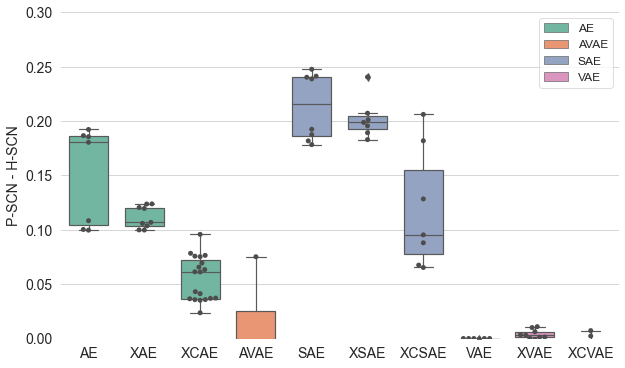

In [112]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium'})   
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
df = df_SCN.sort_values(by=["model_family","model_type"])
palette="Set2"
b = sns.boxplot(x='model_name',y="delta", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.0,.3))
sns.swarmplot(x='model_name',y="delta", data=df, color=".3").set(xlabel=None, ylabel="P-SCN - H-SCN")
ax.legend(ncol=1, loc="upper right", frameon=True, fontsize=12)
sns.despine(left=True, bottom=True)

In [75]:

fname = fig_path / ("SCN_hybrid.png")
fig.savefig(fname, bbox_inches='tight', pad_inches=0)
print(f"Saving to {fname}")

Saving to figures\SCN_hybrid.png


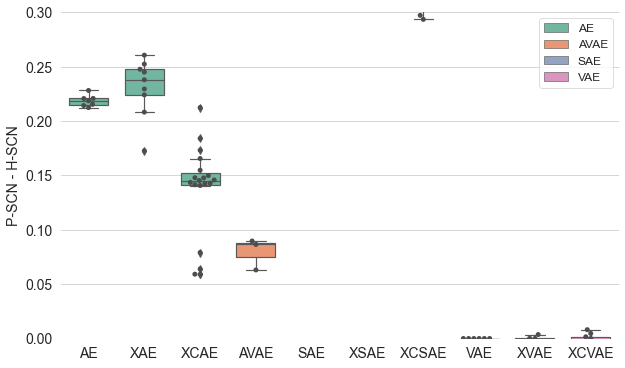

In [114]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium'})   
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
df = df_SCN.sort_values(by=["model_family","model_type"])
palette="Set2"
b = sns.boxplot(x='model_name',y="delta+", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.0,.3))
sns.swarmplot(x='model_name',y="delta+", data=df, color=".3").set(xlabel=None, ylabel="P-SCN - H-SCN")
ax.legend(ncol=1, loc="upper right", frameon=True, fontsize=12)
sns.despine(left=True, bottom=True)

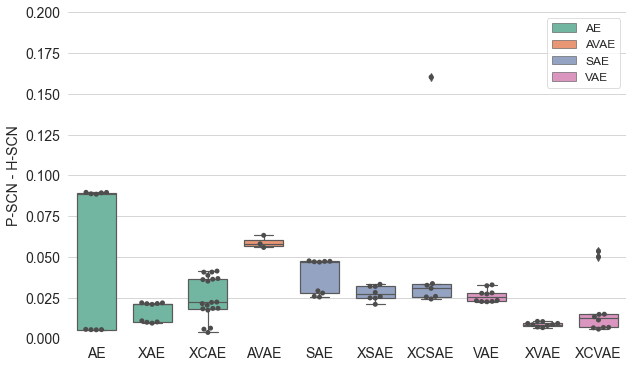

In [113]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,'xtick.labelsize': 'medium',
 'ytick.labelsize': 'medium'})   
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,6))
df = full_df2.sort_values(by=["model_family","model_type"])
palette="Set2"
b = sns.boxplot(x='model_name',y="IMQ", data=df,  
            palette=palette, hue="model_family", 
            dodge=False, width=.7).set(xlabel=None, ylabel=None, ylim=(0.0,.2))
sns.swarmplot(x='model_name',y="IMQ", data=df, color=".3").set(xlabel=None, ylabel="P-SCN - H-SCN")
ax.legend(ncol=1, loc="upper right", frameon=True, fontsize=12)
sns.despine(left=True, bottom=True)

## Actual SCN scores

In [24]:
full_df2.columns

Index(['model_name', 'model_version', 'dataset', 'random_seed', 'RBF', 'IMQ',
       'CAT', 'dCOV', 'DCI', 'IRS', 'MIG', 'ModExp', 'SAP', 'FID_rec',
       'FID_gen', 'FID_trv', 'INV', 'INV_w', 'EQV', 'EQV_w', 'sparsity', 'SCN',
       'SCN_w', 'inference', 'inferenceX', 'PLC', 'RLC', 'DCIR_dis',
       'DCIR_cmplt', 'SCN_posterior', 'SCN_hybrid', 'SCN_uniform', 'SCN+',
       'SCN++', 'model_family', 'model_type'],
      dtype='object')

In [25]:
df_SCN = full_df2[["dataset","model_name","model_family","model_type","SCN","SCN+","SCN++"]].dropna() #8 nan
df_SCN["SCN_delta5"] = df_SCN["SCN"] - df_SCN["SCN+"]
df_SCN["SCN_delta10"] = df_SCN["SCN"] - df_SCN["SCN++"]
df_SCN.sort_values(by="SCN_delta5", ascending=False).head(40)
#df_SCN = df_SCN.drop(df_SCN.loc[df_SCN['dataset']=="Pendulum"].index)
#df_SCN

,dataset,model_name,model_family,model_type,SCN,SCN+,SCN++,SCN_delta5,SCN_delta10
76,MNIST,XCVAE,VAE,XC,0.252108,-0.256048,-0.356207,0.508156,0.608315
94,MNIST,XCAE,AE,XC,0.793200,0.285683,-0.094234,0.507517,0.887434
101,MNIST,XCAE,AE,XC,0.838623,0.347604,-0.134710,0.491019,0.973334
91,MNIST,XCVAE,VAE,XC,0.000490,-0.472322,-0.461016,0.472811,0.461505
104,MNIST,XCAE,AE,XC,0.818473,0.377656,0.032533,0.440818,0.785941
92,MNIST,XCVAE,VAE,XC,0.245702,-0.191792,-0.227010,0.437494,0.472713
98,MNIST,XCAE,AE,XC,0.855294,0.432205,0.014029,0.423089,0.841265
97,MNIST,XCAE,AE,XC,0.838857,0.456283,0.139824,0.382574,0.699033
95,MNIST,XCAE,AE,XC,0.867363,0.492330,0.186580,0.375033,0.680784
82,MNIST,XCVAE,VAE,XC,0.550140,0.176576,0.058398,0.373564,0.491743


In [28]:
res = df_SCN.groupby(by=["model_family","model_type"], as_index=False).agg({'SCN':['median','std'],'SCN+':['mean','std'], 
                                                                            'SCN_delta5':['mean','std'], 'SCN_delta10':['mean','std']})
res.sort_values(by=[('SCN_delta5','mean'),"model_family"], ascending=False)

model_family model_type       SCN                SCN+           SCN_delta5  \
                             median       std      mean       std       mean   
2           AE         XC  0.914604  0.052224  0.648172  0.197756   0.250932   
3         AVAE          N  0.516737  0.033948  0.276837  0.026600   0.239288   
6          SAE         XC  0.861438  0.104946  0.613698  0.091769   0.221689   
9          VAE         XC  0.456813  0.167167  0.203621  0.291316   0.212317   
7          VAE          N  0.359060  0.054882  0.187126  0.002921   0.170843   
0           AE          N  0.965318  0.143658  0.702538  0.242803   0.148120   
4          SAE          N  0.862798  0.056296  0.715238  0.082132   0.146168   
5          SAE          X  0.858889  0.050357  0.713724  0.064007   0.139015   
1           AE          X  0.930119  0.016802  0.785722  0.034935   0.132408   
8          VAE          X  0.437344  0.114162  0.354059  0.077185   0.085736   

            SCN_delta10            
        std        mean       std  
2  0.146404    0.459645  0.278188  
3  0.019391    0.325204  0.018604  
6  0.086106    0.382343  0.166935  
9  0.159754    0.290535  0.153998  
7  0.057197    0.175128  0.057521  
0  0.099345    0.237299  0.152801  
4  0.026447    0.229025  0.036254  
5  0.017147    0.218453  0.015039  
1  0.019350    0.216966  0.027466  
8  0.037486    0.128402  0.055063

In [210]:
res

model_family model_name       SCN           SCN_median
                             median       std           
0           AE         AE  0.860115  0.134580   0.860115
1           AE        XAE  0.916138  0.017070   0.916138
2           AE       XCAE  0.915326  0.051716   0.915326
3         AVAE       AVAE  0.489569  0.021020   0.489569
4          SAE        SAE  0.813456  0.059222   0.813456
5          SAE      XCSAE  0.861438  0.104946   0.861438
6          SAE       XSAE  0.831984  0.047610   0.831984
7          VAE        VAE  0.349538  0.052330   0.349538
8          VAE      XCVAE  0.542605  0.171345   0.542605
9          VAE       XVAE  0.467674  0.107895   0.467674

In [212]:
res["SCN_median"] = res["SCN"]["median"]
res2 = res.groupby(by=["model_family"], as_index=False).agg({('SCN_median',''):['mean','std']})
res2

model_family SCN_median          
                                   
                     mean       std
0           AE   0.897193  0.032113
1         AVAE   0.489569       NaN
2          SAE   0.835626  0.024198
3          VAE   0.453272  0.097336

In [218]:
res2.columns = res2.columns.droplevel(1)

In [219]:
res2

model_family SCN_median          
                     mean       std
0           AE   0.897193  0.032113
1         AVAE   0.489569       NaN
2          SAE   0.835626  0.024198
3          VAE   0.453272  0.097336

In [220]:
resM = res.merge(res2, how="inner",on="model_family")

C:\Users\Giulia\miniconda3\envs\SAE\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [221]:
resM

model_family model_name       SCN           SCN_median                    
                             median       std                 mean       std
0           AE         AE  0.860115  0.134580   0.860115  0.897193  0.032113
1           AE        XAE  0.916138  0.017070   0.916138  0.897193  0.032113
2           AE       XCAE  0.915326  0.051716   0.915326  0.897193  0.032113
3         AVAE       AVAE  0.489569  0.021020   0.489569  0.489569       NaN
4          SAE        SAE  0.813456  0.059222   0.813456  0.835626  0.024198
5          SAE      XCSAE  0.861438  0.104946   0.861438  0.835626  0.024198
6          SAE       XSAE  0.831984  0.047610   0.831984  0.835626  0.024198
7          VAE        VAE  0.349538  0.052330   0.349538  0.453272  0.097336
8          VAE      XCVAE  0.542605  0.171345   0.542605  0.453272  0.097336
9          VAE       XVAE  0.467674  0.107895   0.467674  0.453272  0.097336

In [222]:
resM["delta"] = resM["SCN"]["median"]-resM["SCN_median"]["mean"]
resM['Xnet'] = resM['model_name'].apply(is_Xnet)
resM

model_family model_name       SCN           SCN_median                      \
                             median       std                 mean       std   
0           AE         AE  0.860115  0.134580   0.860115  0.897193  0.032113   
1           AE        XAE  0.916138  0.017070   0.916138  0.897193  0.032113   
2           AE       XCAE  0.915326  0.051716   0.915326  0.897193  0.032113   
3         AVAE       AVAE  0.489569  0.021020   0.489569  0.489569       NaN   
4          SAE        SAE  0.813456  0.059222   0.813456  0.835626  0.024198   
5          SAE      XCSAE  0.861438  0.104946   0.861438  0.835626  0.024198   
6          SAE       XSAE  0.831984  0.047610   0.831984  0.835626  0.024198   
7          VAE        VAE  0.349538  0.052330   0.349538  0.453272  0.097336   
8          VAE      XCVAE  0.542605  0.171345   0.542605  0.453272  0.097336   
9          VAE       XVAE  0.467674  0.107895   0.467674  0.453272  0.097336   

      delta   Xnet  
                    
0 -0.037078  False  
1  0.018945   True  
2  0.018133   True  
3  0.000000  False  
4 -0.022170  False  
5  0.025812   True  
6 -0.003642   True  
7 -0.103734  False  
8  0.089332   True  
9  0.014402   True

In [223]:
resM.sort_values(by=["model_family","delta"])

model_family model_name       SCN           SCN_median                      \
                             median       std                 mean       std   
0           AE         AE  0.860115  0.134580   0.860115  0.897193  0.032113   
2           AE       XCAE  0.915326  0.051716   0.915326  0.897193  0.032113   
1           AE        XAE  0.916138  0.017070   0.916138  0.897193  0.032113   
3         AVAE       AVAE  0.489569  0.021020   0.489569  0.489569       NaN   
4          SAE        SAE  0.813456  0.059222   0.813456  0.835626  0.024198   
6          SAE       XSAE  0.831984  0.047610   0.831984  0.835626  0.024198   
5          SAE      XCSAE  0.861438  0.104946   0.861438  0.835626  0.024198   
7          VAE        VAE  0.349538  0.052330   0.349538  0.453272  0.097336   
9          VAE       XVAE  0.467674  0.107895   0.467674  0.453272  0.097336   
8          VAE      XCVAE  0.542605  0.171345   0.542605  0.453272  0.097336   

      delta   Xnet  
                    
0 -0.037078  False  
2  0.018133   True  
1  0.018945   True  
3  0.000000  False  
4 -0.022170  False  
6 -0.003642   True  
5  0.025812   True  
7 -0.103734  False  
9  0.014402   True  
8  0.089332   True

## Sparsity

In [45]:
sdf = full_df2.loc[full_df2['sparsity'].dropna().index][["dataset","model_name","model_family","model_type","sparsity","model_version"]]
sdf

,dataset,model_name,model_family,model_type,sparsity,model_version
3,MNIST,XVAE,VAE,X,0.208333,standardS
4,MNIST,XAE,AE,X,0.208333,standardS
5,MNIST,XSAE,SAE,X,0.208333,standardS
8,MNIST,XAE,AE,X,0.229167,standard
9,MNIST,XVAE,VAE,X,0.229167,standard
...,...,...,...,...,...,...
121,MNIST,XVAE,VAE,X,0.229167,standard
122,MNIST,XCVAE,VAE,XC,0.229167,standard
123,MNIST,XCAE,AE,XC,0.229167,standard
124,MNIST,XVAE,VAE,X,0.229167,standard


In [46]:
res = sdf.groupby(by=["model_family","dataset","model_version"], as_index=False).agg({'sparsity':['mean','std']})
res.sort_values(by=["model_family",('sparsity','mean')], ascending=False)

model_family   dataset model_version  sparsity              
                                             mean           std
10          VAE     MNIST      standard  0.229167  0.000000e+00
13          VAE     MNIST    xunit_dim4  0.208334  0.000000e+00
14          VAE     MNIST    xunit_dim7  0.208333  7.450581e-09
11          VAE     MNIST     standardS  0.208333  1.126422e-08
12          VAE     MNIST    standardSE  0.208333  0.000000e+00
15          VAE  Pendulum       conv_pd  0.187500  6.322027e-08
6           SAE     MNIST      standard  0.229167  8.161702e-09
9           SAE     MNIST    xunit_dim4  0.208333           NaN
7           SAE     MNIST     standardS  0.208333  1.490116e-08
8           SAE     MNIST    standardSE  0.208333  7.450581e-09
0            AE     MNIST      standard  0.229167  1.490116e-08
3            AE     MNIST    xunit_dim4  0.208334  0.000000e+00
4            AE     MNIST    xunit_dim7  0.208333  8.603189e-09
2            AE     MNIST    standardSE  0.208333  0.000000e+00
1            AE     MNIST     standardS  0.208333  1.226772e-08
5            AE  Pendulum       conv_pd  0.187500           NaN

## DCIR and Disentanglement (Pendulum)

In [26]:
PD_df = full_df2.loc[full_df2["dataset"]=="Pendulum"]
PD_df

,model_name,model_version,dataset,random_seed,RBF,IMQ,CAT,dCOV,DCI,IRS,...,RLC,DCIR_dis,DCIR_cmplt,SCN_posterior,SCN_hybrid,SCN_uniform,SCN+,SCN++,model_family,model_type
11,AE,conv_pd,Pendulum,11.0,0.010822,0.092151,-240.750061,1.993546,0.021883,0.846373,...,0.514437,0.290420,0.297558,0.995421,0.500161,0.359294,NaN,NaN,AE,N
12,XAE,conv_pd,Pendulum,11.0,0.002795,0.077281,-72.908936,0.980139,0.044247,0.940769,...,0.623312,0.552174,0.552657,0.996545,0.696434,0.648589,NaN,NaN,AE,X
13,XCAE,conv_pd,Pendulum,11.0,0.004100,0.093998,-63.338112,0.855153,0.053809,0.884484,...,0.200187,0.020206,0.324635,0.000000,0.000000,0.000000,NaN,NaN,AE,XC
14,VAE,conv_pd,Pendulum,11.0,0.003748,0.044017,-24.513256,0.309212,0.106158,0.813553,...,0.478250,0.112680,0.273103,0.366739,0.411888,0.317697,NaN,NaN,VAE,N
15,XVAE,conv_pd,Pendulum,11.0,0.001439,0.007410,-16.952648,0.165396,0.073438,0.938842,...,0.397250,0.097749,0.209000,0.191893,0.228741,0.253644,NaN,NaN,VAE,X
16,XCVAE,conv_pd,Pendulum,11.0,0.004842,0.144326,-30.659861,0.447413,0.030244,0.846020,...,0.556125,0.269174,0.413821,0.465300,0.451421,0.377673,NaN,NaN,VAE,XC
126,CausalVAE,fc_pd_1D,Pendulum,11.0,0.013108,0.370738,-68.255051,1.131688,0.021607,0.767278,...,0.206187,0.028597,0.056837,0.000000,0.000000,0.000000,-1.423297,-1.435666,CausalVAE,N


In [27]:
PD_df.columns

Index(['model_name', 'model_version', 'dataset', 'random_seed', 'RBF', 'IMQ',
       'CAT', 'dCOV', 'DCI', 'IRS', 'MIG', 'ModExp', 'SAP', 'FID_rec',
       'FID_gen', 'FID_trv', 'INV', 'INV_w', 'EQV', 'EQV_w', 'sparsity', 'SCN',
       'SCN_w', 'inference', 'inferenceX', 'PLC', 'RLC', 'DCIR_dis',
       'DCIR_cmplt', 'SCN_posterior', 'SCN_hybrid', 'SCN_uniform', 'SCN+',
       'SCN++', 'model_family', 'model_type'],
      dtype='object')

In [28]:
PD_df = PD_df[["model_type","model_family","DCI","IRS","MIG","ModExp","SAP","DCIR_cmplt","DCIR_dis"]]
PD_df['Xnet'] = PD_df['model_type'].apply(is_Xnet)
PD_df

C:\Users\Giulia\miniconda3\envs\SAE\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,model_type,model_family,DCI,IRS,MIG,ModExp,SAP,DCIR_cmplt,DCIR_dis,Xnet
11,N,AE,0.021883,0.846373,0.072105,0.610668,0.0310,0.297558,0.290420,False
12,X,AE,0.044247,0.940769,0.030021,0.729261,0.0145,0.552657,0.552174,True
13,XC,AE,0.053809,0.884484,0.055298,0.701585,0.0385,0.324635,0.020206,True
14,N,VAE,0.106158,0.813553,0.101076,0.579751,0.0160,0.273103,0.112680,False
15,X,VAE,0.073438,0.938842,0.092671,0.613443,0.0225,0.209000,0.097749,True
16,XC,VAE,0.030244,0.846020,0.035974,0.602686,0.0200,0.413821,0.269174,True
126,N,CausalVAE,0.021607,0.767278,0.028305,0.581153,0.0430,0.056837,0.028597,False


In [29]:
PD_df.sort_values(by=["model_family","DCIR_dis"])

,model_type,model_family,DCI,IRS,MIG,ModExp,SAP,DCIR_cmplt,DCIR_dis,Xnet
13,XC,AE,0.053809,0.884484,0.055298,0.701585,0.0385,0.324635,0.020206,True
11,N,AE,0.021883,0.846373,0.072105,0.610668,0.0310,0.297558,0.290420,False
12,X,AE,0.044247,0.940769,0.030021,0.729261,0.0145,0.552657,0.552174,True
126,N,CausalVAE,0.021607,0.767278,0.028305,0.581153,0.0430,0.056837,0.028597,False
15,X,VAE,0.073438,0.938842,0.092671,0.613443,0.0225,0.209000,0.097749,True
14,N,VAE,0.106158,0.813553,0.101076,0.579751,0.0160,0.273103,0.112680,False
16,XC,VAE,0.030244,0.846020,0.035974,0.602686,0.0200,0.413821,0.269174,True


Text(10.46, 0.5, 'SAP')

<Figure size 864x864 with 0 Axes>

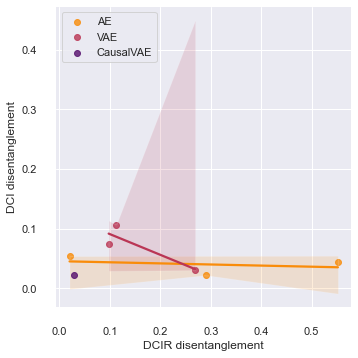

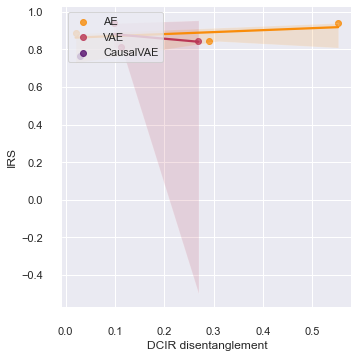

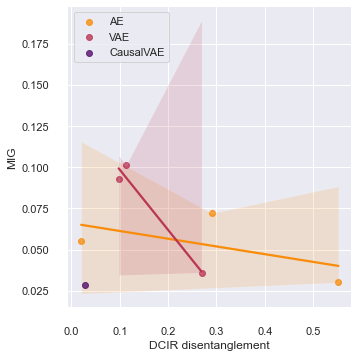

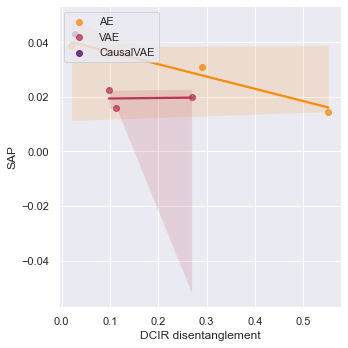

In [30]:
import seaborn as sns
%matplotlib inline
sns.axes_style("white")
sns.set_context("poster")
sns.set(rc={'figure.figsize':(12,12)})

sns.despine(offset=10, trim=True);
g1 = sns.lmplot(data=PD_df,x="DCIR_dis", y="DCI", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='upper left')
plt.xlabel("DCIR disentanglement")
plt.ylabel("DCI disentanglement")

sns.despine(offset=10, trim=True);
g1 = sns.lmplot(data=PD_df,x="DCIR_dis", y="IRS", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='upper left')
plt.xlabel("DCIR disentanglement")
plt.ylabel("IRS")

sns.despine(offset=10, trim=True);
g1 = sns.lmplot(data=PD_df,x="DCIR_dis", y="MIG", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='upper left')
plt.xlabel("DCIR disentanglement")
plt.ylabel("MIG")


sns.despine(offset=10, trim=True);
g1 = sns.lmplot(data=PD_df,x="DCIR_dis", y="SAP", hue="model_family",height=5, palette="inferno_r", legend=False)
plt.legend(loc='upper left')
plt.xlabel("DCIR disentanglement")
plt.ylabel("SAP")